## Flow Loop Analysis Notebook

Synchronizes the start times of data files from a flow loop experiment, combines them into a single dataframe, and plots them.

### Mandatory File Inputs:
- LabVIEW Flow Loop File (.lvm)

### Optional File Inputs:
- Mistras AE Primary (Hits-Based) Data File (.txt)
- Mistras AE Time-Driven Data File (.txt)
- PSCS Power Supply Data File (.csv)
- Manually-Produced Two-Phase Activity Timespans File (.csv)

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from scipy import signal
import os
from datetime import datetime, timedelta
import re

In [2]:
def is_number(s):
    # Define a regex pattern to match positive, negative, and decimal numbers
    number_pattern = re.compile(r'^-?(\d+(\.\d*)?|\.\d+)$')
    
    # Use the pattern to check if the string matches
    return bool(number_pattern.match(s))

def truncate_microseconds(dt_str):
    # Split the time string at the decimal point
    if '.' in dt_str:
        time_part, microseconds_part = dt_str.split('.')
        # Truncate to only the first six digits of microseconds
        truncated_microseconds_part = microseconds_part[:6]
        truncated_dt_str = f"{time_part}.{truncated_microseconds_part}"
        return truncated_dt_str
    return dt_str

In [3]:
experiment_raw_df = {}

## Import FL Dataframe

In [4]:
FL_filepath = ""
while True:
    # Specify the file path directly
    filename = input("Please enter the name of your flow loop .lvm or .txt file: ")
    folder = input("Please enter the full path (not including the filename) to your .lvm or .txt file: ")

    if folder:
        FL_filepath = folder + "\\" + filename
    else: 
        FL_filepath = filename

    print("\nFlow Loop Data Filepath: ", FL_filepath)

    if os.path.isfile(FL_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")


Flow Loop Data Filepath:  C:\Users\sapierso\OneDrive - University of Arkansas\Documents\GitHub\NED3-Flow-Loop-Analysis\combined-flow-loop-ae\example-files\FL-71-flow-loop.lvm


In [5]:
def get_lvm_metadata(filepath):
    header_found = False
    metadata = {}
    with open(filepath, 'r') as file:
        for line in file:
            if header_found:
                if line.startswith("Time"):
                    current_line = line
                    # Split the line to extract the datetime string
                    _ , sensor_start_times_str = current_line.split('\t',1)
                    sensor_start_times = sensor_start_times_str.split('\t')
                    start_time = sensor_start_times[0]
                    start_time_trunc = truncate_microseconds(start_time)
                    lvm_start_time_obj = datetime.strptime(start_time_trunc, "%H:%M:%S.%f")
                    metadata['start_time'] = lvm_start_time_obj
                if line.startswith("Delta_X"):
                    current_line = line
                    # Split the line to extract the datetime string
                    _ , sampling_periods_str = current_line.split('\t',1)
                    sampling_periods = sampling_periods_str.split('\t')
                    metadata['sampling_period'] = float(sampling_periods[0])
                    break
            elif "***End_of_Header***" in line:
                header_found = True
        lines = file.readlines()
        final_line = lines[len(lines)-1]
        experiment_duration, _ = final_line.split("\t",1)
        metadata['duration'] = float(experiment_duration)
        # Iterate through each line in the file
    return metadata
    

def import_lvm_to_df(filepath):
    # Find the second occurrence of the header line containing '***End_of_Header***' which indicates beginning of dataframe
    header_count = 0
    header_line_index = 0
    with open(filepath, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines[:50]):  # Check the first 50 lines
            if '***End_of_Header***' in line:
                header_count += 1
                if header_count == 2:
                    header_line_index = i + 1
                    break

    # Read the file, handling the case where the 2nd header marker is not found
    if header_count == 2:
        raw_df = pd.read_csv(filepath, delimiter='\t', header=header_line_index)
    else:
        raw_df = pd.read_csv(filepath, delimiter='\t', header=0)  # Assume first line is header
    return raw_df

def process_lvm_data(df, metadata):
    lvm_start_time_obj = metadata['start_time']
    
    # Create a timedelta for each row based on seconds
    seconds = df['X_Value']
    time_deltas = pd.to_timedelta(seconds, unit='s')

    # Adding the timedelta to the start time to get the absolute times
    absolute_time = lvm_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)
    df = df.drop('Comment', axis=1)
    # Define column names for the LabVIEW data based on the expected data structure from the processed dataframe
    FL_columns = [
        'Absolute Time',
        'X_Value', 
        'Test Section Heater (degC)', 
        'Inline Heater (degC)', 
        'Pressure Drop (kPa)', 
        'Inlet Temperature (degC)', 
        'Outlet Temperature (degC)', 
        'Flow Rate Signal',
    ]
    if len(df.columns) == 9:
        FL_columns.append('Post Preheater Temperature (degC)')
        
    df.columns = FL_columns
    return df

FL_metadata = get_lvm_metadata(FL_filepath)
print("LabVIEW Start Time: " + str(FL_metadata['start_time']))
print("Duration: " + str(FL_metadata['duration']) + " s")
print("Sampling Period: " + str(FL_metadata['sampling_period']) + " s")
raw_df = import_lvm_to_df(FL_filepath)
raw_df = process_lvm_data(raw_df, FL_metadata)

experiment_raw_df['FL_data'] = {'metadata': FL_metadata, 'df': raw_df}

display(raw_df)

LabVIEW Start Time: 1900-01-01 15:17:06.191197
Duration: 439.57938 s
Sampling Period: 0.00062 s


,Absolute Time,X_Value,Test Section Heater (degC),Inline Heater (degC),Pressure Drop (kPa),Inlet Temperature (degC),Outlet Temperature (degC),Flow Rate Signal,Post Preheater Temperature (degC)
0,1900-01-01 15:17:06.191197,0.00000,108.522986,96.553326,0.884683,95.007240,96.542398,0.084484,95.283812
1,1900-01-01 15:17:06.191817,0.00062,108.522778,96.553308,0.889084,95.007240,96.542398,-0.097194,95.283812
2,1900-01-01 15:17:06.192437,0.00124,108.522569,96.553290,0.886466,95.007240,96.542398,0.828464,95.283812
3,1900-01-01 15:17:06.193057,0.00186,108.522361,96.553273,0.888723,95.007240,96.542398,3.860190,95.283812
4,1900-01-01 15:17:06.193677,0.00248,108.522153,96.553258,0.888452,95.007240,96.542398,4.437098,95.283812
...,...,...,...,...,...,...,...,...,...
708995,1900-01-01 15:24:25.768097,439.57690,108.528637,96.485282,0.837871,94.945858,96.445190,4.983931,95.226432
708996,1900-01-01 15:24:25.768717,439.57752,108.528667,96.484874,0.841708,94.945858,96.445190,1.818574,95.226432
708997,1900-01-01 15:24:25.769337,439.57814,108.528698,96.484467,0.838616,94.945858,96.445190,0.002530,95.226432
708998,1900-01-01 15:24:25.769957,439.57876,108.528729,96.484062,0.841099,94.945858,96.445190,0.099203,95.226432


## Import PSCS (Test Section Power Supply) Dataframe

In [6]:
skip_PSCS_import = False
PSCS_filepath = ""
while True:
    # Specify the file path directly
    filename = input("Please enter the name of your heater power supply .csv file (Enter 'None' to skip PSU import): ")
    if filename.strip().lower() == 'none':
        skip_PSCS_import = True
        break
    folder = input("Please enter the full path (not including the filename) to your .csv file: ")

    if folder:
        PSCS_filepath = folder + "\\" + filename
    else: 
        PSCS_filepath = filename

    print("\nHeater Power Supply Data Filepath: ", PSCS_filepath)

    if os.path.isfile(PSCS_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")


Heater Power Supply Data Filepath:  C:\Users\sapierso\OneDrive - University of Arkansas\Documents\GitHub\NED3-Flow-Loop-Analysis\combined-flow-loop-ae\example-files\FL-71-PSCS-power-supply.csv


In [7]:
def get_PSCS_csv_metadata(filepath):
    metadata = {}

    with open(filepath, 'r') as file:
        duration = 0
        # Iterate through each line in the file
        for line in file:
            
            if line.startswith("StartTime:"):
                # Split the line to extract the date string
                _ , date_time_str = line.split(':',1)
                date_time_str = date_time_str.strip()
                # Parse the date/time string to a datetime object
                date_time_obj = datetime.strptime(date_time_str, "%b %d, %Y %I:%M:%S %p")
                # Convert to 24-hour format with microsecond precision
                formatted_time_str = date_time_obj.strftime("%H:%M:%S.%f")
                start_time = datetime.strptime(formatted_time_str, '%H:%M:%S.%f')
                metadata['start_time'] = start_time
                
            if line.startswith("Sampling:"):
                # Split the line to extract the integer value
                parts = line.split(':',1)
                # Extract the integer part and remove any non-digit characters
                sampling_period = ''.join(filter(str.isdigit, parts[1]))
                # Convert the string to an integer
                sampling_period = int(sampling_period)
                metadata['sampling_period'] = sampling_period
                
            if line.startswith("Rec:"):
                match = re.search(r"Rec:(\d+)", line)
                if match:
                    duration = float(match.group(1))
                    
        metadata['duration'] = duration
    return metadata

def import_PSCS_csv_to_df(filepath):
    raw_df = pd.read_csv(filepath, delimiter=',', header=4)
    return raw_df

def process_PSCS_data(df, metadata, exp_start_time_obj:str=None, exp_duration=None):
    # Add 'Absolute time' column to the data
    PSCS_start_time_obj = metadata['start_time']
    seconds = df.index * metadata['sampling_period']
    time_deltas = pd.to_timedelta(seconds, unit='s')
    absolute_time = PSCS_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)

    # # Trim the dataframe to the timeframe of the experiment
    # if exp_start_time_obj:
    #     td = exp_start_time_obj - PSCS_start_time_obj
    #     time_difference = td.total_seconds()
    #     # Lop off the file before the experiment start
    #     data = data.iloc[(np.floor(time_difference/metadata['sampling_period']).astype(int)):]
    
    # if exp_duration:
    #     data = data.iloc[:(np.ceil(exp_duration/metadata['sampling_period']+1).astype(int))]
    
    # Drop useless ID column
    df = df.drop('Record:ID', axis=1)
    
    # Insert Time column based on sampling rate in header metadata
    time_column = range(0, metadata['sampling_period'] * len(df), metadata['sampling_period'])
    df.insert(1, 'Time(s)', time_column)
    
    # Add Power column
    df.loc[:, 'Power(W)'] = df['Voltage(mV)'] / 1000 * df['Current(mA)'] / 1000
    
    # Reset index column
    df = df.reset_index(drop=True)
    
    return df

if not skip_PSCS_import:
    PSCS_metadata = get_PSCS_csv_metadata(PSCS_filepath)
    print("PSCS Sampling Period: " + str(PSCS_metadata['sampling_period']) + "s")
    print("PSCS Start Time:", PSCS_metadata['start_time'])
    print("PSCS Duration:", PSCS_metadata['duration'])
    PSCS_data = import_PSCS_csv_to_df(PSCS_filepath)
    PSCS_data = process_PSCS_data(
        PSCS_data, 
        PSCS_metadata, 
        exp_start_time_obj=FL_metadata['start_time'], 
        exp_duration=FL_metadata['duration']
    )

    experiment_raw_df['PSCS_data'] = {'metadata': PSCS_metadata, 'df': PSCS_data}

    display(PSCS_data)

PSCS Sampling Period: 1s
PSCS Start Time: 1900-01-01 15:16:03
PSCS Duration: 498.0


,Absolute Time,Time(s),Voltage(mV),Current(mA),Power(W)
0,1900-01-01 15:16:03,0,35900,2920,104.828
1,1900-01-01 15:16:04,1,35900,2920,104.828
2,1900-01-01 15:16:05,2,35900,2920,104.828
3,1900-01-01 15:16:06,3,35900,2920,104.828
4,1900-01-01 15:16:07,4,35900,2920,104.828
...,...,...,...,...,...
494,1900-01-01 15:24:17,494,23900,2020,48.278
495,1900-01-01 15:24:18,495,23900,2020,48.278
496,1900-01-01 15:24:19,496,23900,2020,48.278
497,1900-01-01 15:24:20,497,23900,2020,48.278


## Import Mistras (AE Sensor) Hits Dataframe

In [8]:
skip_mistras_import = False
Mistras_filepath = ""
while True:
    # Specify the file path directly
    filename = input("Please enter the name of your Mistras .txt file (Enter 'None' to skip Mistras import): ")
    if filename.strip().lower() == 'none':
        skip_mistras_import = True
        break
    folder = input("Please enter the full path (not including the filename) to your .txt file: ")

    if folder:
        Mistras_filepath = folder + "\\" + filename
    else: 
        Mistras_filepath = filename

    print("\nMistras Data Filepath: ", Mistras_filepath)

    if os.path.isfile(Mistras_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")


Mistras Data Filepath:  C:\Users\sapierso\OneDrive - University of Arkansas\Documents\GitHub\NED3-Flow-Loop-Analysis\combined-flow-loop-ae\example-files\FL-71_mistras-ae-primary-data.txt


In [9]:
def get_mistras_metadata(filepath, df):
    metadata = {}
    
    # This regex pattern matches a time format and optionally captures microseconds if present
    time_pattern = re.compile(r'\b(\d{2}:\d{2}:\d{2})(?:\.(\d+))?\b')
    
    with open(filepath, 'r') as file:
        for line in file:
            match = re.search(time_pattern, line)
            if match:
                time_str = match.group(1)  # Time in HH:MM:SS
                microseconds_str = match.group(2) if match.group(2) else '000000'  # Microseconds part if present, else '0'
                break
        else:
            # Handle case where no time is found
            return None

    # Append microseconds to the time string and parse
    full_time_str = f"{time_str}.{microseconds_str}"
    time_obj = datetime.strptime(full_time_str, "%H:%M:%S.%f")

    metadata['start_time'] = time_obj
    metadata['duration'] = df['SSSSSSSS.mmmuuun'].iloc[-1]
    return metadata

def import_mistras_file_to_df(filepath):
    # Read the data using read_csv, assuming tab-separated values (TSV); adjust delimiter if needed
    df = pd.read_csv(filepath, delim_whitespace=True, header=4)
    # There is a bad import on the 'SIG STRNGTH col because it has a space in the name and the file is whitespace-delimted
    column_names = [
        'ID', 'SSSSSSSS.mmmuuun', 'CH', 'RISE', 'COUN', 'ENER', 
        'DURATION', 'AMP', 'A-FRQ', 'RMS', 'ASL', 'PCNTS', 'THR', 'R-FRQ', 
        'I-FRQ', 'SIG STRNGTH', 'ABS-ENERGY'
    ]
    # Keep all columns except the last one
    df = df.iloc[:, :-1]
    df.columns = column_names
    return df

def process_mistras_df(df, metadata):
    # Drop 'ID' col
    df = df.drop('ID', axis=1)
    # Rename time col
    df.rename(columns={'SSSSSSSS.mmmuuun': 'TIME'}, inplace=True)
    
    # Add 'Absolute time' column to the data
    mistras_start_time_obj = metadata['start_time']
    seconds = df['TIME']
    time_deltas = pd.to_timedelta(seconds, unit='s')
    absolute_time = mistras_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)
    
    return df

if not skip_mistras_import:
    mistras_df = import_mistras_file_to_df(Mistras_filepath)
    mistras_metadata = get_mistras_metadata(Mistras_filepath, mistras_df)
    mistras_df = process_mistras_df(mistras_df, mistras_metadata)
    print("Start time:", mistras_metadata['start_time'])
    print("Duration: " + str(mistras_metadata['duration']) + " s")

    experiment_raw_df['mistras_df'] = {'metadata': mistras_metadata, 'df': mistras_df}

    display(mistras_df)

C:\Users\sapierso\AppData\Local\Temp\ipykernel_16804\3178745171.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, header=4)


Start time: 1900-01-01 15:17:05
Duration: 412.1037095 s


,Absolute Time,TIME,CH,RISE,COUN,ENER,DURATION,AMP,A-FRQ,RMS,ASL,PCNTS,THR,R-FRQ,I-FRQ,SIG STRNGTH,ABS-ENERGY
0,1900-01-01 15:17:05.287261000,0.287261,1,52,1,0,54,31,18,0.0006,19,1,30,1,19,1180.00,3.145000
1,1900-01-01 15:17:05.947150800,0.947151,1,52,1,0,54,29,18,0.0006,19,1,30,1,19,1180.00,3.145000
2,1900-01-01 15:17:05.947921800,0.947922,1,1,1,0,1,30,1000,0.0006,19,1,30,1000,1000,30.50,0.107065
3,1900-01-01 15:17:06.206834500,1.206835,1,45,1,0,73,31,13,0.0006,20,1,30,1,22,2327.00,8.020000
4,1900-01-01 15:17:06.230680300,1.230680,1,45,1,0,1,30,1000,0.0008,20,1,30,1000,22,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66875,1900-01-01 15:23:56.388717800,411.388718,1,27,1,0,60,30,16,0.0008,21,1,30,1,37,1790.00,5.813000
66876,1900-01-01 15:23:56.708281800,411.708282,1,27,1,0,1,30,1000,0.0008,21,1,30,1000,37,0.00,0.000000
66877,1900-01-01 15:23:56.878494800,411.878495,1,28,1,0,65,31,15,0.0008,21,1,30,1,35,2040.00,6.959000
66878,1900-01-01 15:23:56.879233500,411.879233,1,10,1,0,26,31,38,0.0008,21,1,30,1,100,808.25,2.764000


## Import Mistras (AE Sensor) Time-Driven Data Dataframe

In [10]:
skip_mistras_tdd_import = False
Mistras_tdd_filepath = ""
while True:
    # Specify the file path directly
    filename = input("Please enter the name of your Mistras TDD .txt file (Enter 'None' to skip import): ")
    if filename.strip().lower() == 'none':
        skip_mistras_tdd_import = True
        break
    folder = input("Please enter the full path (not including the filename) to your .txt file: ")

    if folder:
        Mistras_tdd_filepath = folder + "\\" + filename
    else: 
        Mistras_tdd_filepath = filename

    print("\nMistras TDD Data Filepath: ", Mistras_tdd_filepath)

    if os.path.isfile(Mistras_tdd_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")


Mistras TDD Data Filepath:  C:\Users\sapierso\OneDrive - University of Arkansas\Documents\GitHub\NED3-Flow-Loop-Analysis\combined-flow-loop-ae\example-files\FL-71-mistras-ae-time-driven-data.txt


In [11]:
def parse_tdd_data(file_path):
    # Initialize lists to store data
    timestamps = []
    rms = []
    asl = []
    thr = []
    abs_energy = []
    
    # Open and read the file
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('  2 '):
                # Extract timestamp
                timestamp = float(line.split()[-1])
                timestamps.append(timestamp)
                
                # Read the next two lines
                _ = next(file)  # Skip the "CH:[    RMS ASL THR  ABS-ENERGY]" line
                channel_data = next(file).strip()
                
                # Extract channel data
                data = channel_data.split('[')[-1].split(']')[0].split()
                rms.append(float(data[0]))
                asl.append(int(data[1]))
                thr.append(int(data[2]))
                abs_energy.append(float(data[3]))
    
    # Create DataFrame
    df = pd.DataFrame({
        'SSSSSSSS.mmmuuun': timestamps,
        'RMS_CONTINUOUS': rms,
        'ASL_CONTINUOUS': asl,
        'THR_CONTINUOUS': thr,
        'ABS_ENERGY_CONTINUOUS': abs_energy
    })
    
    return df

def process_mistras_tdd_df(df, metadata):
    # Rename time col
    df.rename(columns={'SSSSSSSS.mmmuuun': 'TIME'}, inplace=True)
    
    # Add 'Absolute time' column to the data
    mistras_start_time_obj = metadata['start_time']
    seconds = df['TIME']
    time_deltas = pd.to_timedelta(seconds, unit='s')
    absolute_time = mistras_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)
    
    return df

if not skip_mistras_tdd_import:
    mistras_tdd_df = parse_tdd_data(Mistras_tdd_filepath)
    mistras_tdd_metadata = get_mistras_metadata(Mistras_tdd_filepath, mistras_tdd_df)
    mistras_tdd_df = process_mistras_tdd_df(mistras_tdd_df, mistras_tdd_metadata)
    print("Start time:", mistras_tdd_metadata['start_time'])
    print("Duration: " + str(mistras_tdd_metadata['duration']) + " s")
    experiment_raw_df['mistras_tdd_df'] = {'metadata': mistras_tdd_metadata, 'df': mistras_tdd_df}
    display(mistras_tdd_df)

Start time: 1900-01-01 15:17:05
Duration: 412.2499408 s


,Absolute Time,TIME,RMS_CONTINUOUS,ASL_CONTINUOUS,THR_CONTINUOUS,ABS_ENERGY_CONTINUOUS
0,1900-01-01 15:17:05.049940700,0.049941,0.0006,19,30,194.674
1,1900-01-01 15:17:05.099940700,0.099941,0.0008,21,30,367.707
2,1900-01-01 15:17:05.149940800,0.149941,0.0008,20,30,203.208
3,1900-01-01 15:17:05.199940800,0.199941,0.0006,20,30,146.067
4,1900-01-01 15:17:05.249940700,0.249941,0.0006,19,30,160.354
...,...,...,...,...,...,...
8240,1900-01-01 15:23:57.049940800,412.049941,0.0008,22,30,413.436
8241,1900-01-01 15:23:57.099940700,412.099941,0.0008,21,30,160.039
8242,1900-01-01 15:23:57.149940700,412.149941,0.0008,22,30,368.267
8243,1900-01-01 15:23:57.199940800,412.199941,0.0008,21,30,213.177


## Import Two-Phase Times CSV
### Done manually and should have the following format:
Start Time,End Time</br>
212.8,213.8</br>
214.9,215.3</br>
...</br>


In [12]:
skip_two_phase_times_import = False
TwoPhaseTimes_filepath = ""
while True:
    # Specify the filepath directly
    filename = input("Please enter the name of your Two Phase Times .csv file (Enter 'None' to skip import): ")
    if filename.strip().lower() == 'none':
        skip_two_phase_times_import = True
        break
    folder = input("Please enter the full path (not including the filename) to your .csv file: ")

    if folder:
        TwoPhaseTimes_filepath = folder + "\\" + filename
    else: 
        TwoPhaseTimes_filepath = filename

    print("\nTwo Phase Times csv Filepath: ", TwoPhaseTimes_filepath)

    if os.path.isfile(TwoPhaseTimes_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")

two_phase_spans = None
if not skip_two_phase_times_import:
    two_phase_times_df = pd.read_csv(TwoPhaseTimes_filepath)
    column_names = two_phase_times_df.columns[:2]
    two_phase_spans = two_phase_times_df[column_names].values.tolist()
    display(two_phase_spans)

## Define Experiment Constants / Calibration Values

In [13]:
# Working fluid constants
cp_l = 4215.7  # J/kgC
rho_l = .95835    # kg/L
h_fg = 2257 * 1000  # kJ/kg (Latent heat of vaporization)
heat_sink_width = 28.326 / 1000  # m (Manifold Microchannel Heat Sink)
heat_sink_length = 28.58 / 1000  # m (Manifold Microchannel Heat Sink)
A_base = heat_sink_width * heat_sink_length

# Empirically-determined coefficients for heat loss to surroundings
### These values valid for Aluminum Straight Microchannel Heat Sink Sample
a = 0.0344  # Coefficient for calculating Q_loss = a*(T_base-b)
b = 24.695  # Coefficient for calculating Q_loss = a*(T_base-b)

# Get differential pressure 'zero' from the user
dP_offset = ""
while True:
    # Specify the file path directly
    dP_offset = input("Enter the value in kPa to 'zero' the differential pressure transducer to: ")
    dP_offset = dP_offset.strip()
    if is_number(dP_offset):
        dP_offset = float(dP_offset)
        break
    print("\nThe specified value is not a valid number. Please try again.")

## Trim Top and Bottom of Dataframes to Match File Start/End Times

In [14]:
# User can override hour, minute, and second fields to trim the data to their liking
latest_start_time = datetime(1900, 1, 1, 0, 0, 0)  # yyyy, mm, dd, hh, mm, ss
earliest_end_time = datetime(1900, 1, 2, 0, 0, 0)

# Find the latest start time and earliest end time among the data files being considered
for key, data in experiment_raw_df.items():
    start_time = data['metadata']['start_time']
    end_time = start_time + timedelta(seconds=data['metadata']['duration'])
    if start_time > latest_start_time:
        latest_start_time = start_time
    if end_time < earliest_end_time and key != 'mistras_df':  
        # Mistras data gets special treatment because it is not taken at regular intervals and is instead threshold-based
        earliest_end_time = end_time

print("Latest file start_time:", latest_start_time)
print("Earliest file end_time:", earliest_end_time)

# Trim the leading and trailing rows of each data frame that fall outside the range [latest_start_time:earliest_end_time]
experiment_trimmed_data = experiment_raw_df
for key, data in experiment_raw_df.items():
    start_time = data['metadata']['start_time']
    duration = data['metadata']['duration']
    end_time = start_time + timedelta(seconds=duration)
    df = data['df']
    
    # Trim rows where 'Absolute Time' is earlier than the latest_start_time
    if start_time < latest_start_time:
        df = df[df['Absolute Time'] >= latest_start_time]

    # Trim rows where 'Absolute Time' is later than the earliest_end_time
    if end_time > earliest_end_time and key != 'mistras_df':
        df = df[df['Absolute Time'] <= earliest_end_time]
    
    # Update the DataFrame in the dictionary after trimming
    experiment_trimmed_data[key]['df'] = df

# Verify new start and end times in each DataFrame
for key, data in experiment_trimmed_data.items():
    df = data['df']
    if key == 'mistras_df' and latest_start_time < df['Absolute Time'].min():
        min_time = latest_start_time
    else:
        min_time = df['Absolute Time'].min()
    if key == 'mistras_df' and earliest_end_time > df['Absolute Time'].max():
        max_time = earliest_end_time
    else:
        max_time = df['Absolute Time'].max()
    print(f"Key: {key}, Min 'Absolute Time': {min_time}, Max 'Absolute Time': {max_time}")

data = None
TestSectionPSU_data = None
AE_data = None
continuous_AE_data = None
# Give each trimmed dataframe a new name
if experiment_trimmed_data.get('FL_data'):
    data = experiment_trimmed_data['FL_data']['df'].copy()
if experiment_trimmed_data.get('PSCS_data'):
    TestSectionPSU_data = experiment_trimmed_data['PSCS_data']['df'].copy()
if experiment_trimmed_data.get('mistras_df'):
    AE_data = experiment_trimmed_data['mistras_df']['df'].copy()
if experiment_trimmed_data.get('mistras_tdd_df'):
    continuous_AE_data = experiment_trimmed_data['mistras_tdd_df']['df'].copy()


Latest file start_time: 1900-01-01 15:17:06.191197
Earliest file end_time: 1900-01-01 15:23:57.249941
Key: FL_data, Min 'Absolute Time': 1900-01-01 15:17:06.191197, Max 'Absolute Time': 1900-01-01 15:23:57.249337
Key: PSCS_data, Min 'Absolute Time': 1900-01-01 15:17:07, Max 'Absolute Time': 1900-01-01 15:23:57
Key: mistras_df, Min 'Absolute Time': 1900-01-01 15:17:06.191197, Max 'Absolute Time': 1900-01-01 15:23:57.249941
Key: mistras_tdd_df, Min 'Absolute Time': 1900-01-01 15:17:06.199940700, Max 'Absolute Time': 1900-01-01 15:23:57.249940800


In [15]:
# # Set start time to begin steady-state assumption, if steady-state throughout use 0
# time = raw_df['X_Value']
# start_time = 0
# end_time = time.iloc[-1]
# print("End Time: " + str(end_time) + " s")

# sample_rate = FL_metadata['sampling_period']  # Get the sample rate from the time column
# print("Sample Rate: " + str(1/sample_rate) + " Hz")
# starting_index = int(round(start_time / sample_rate))
# ending_index = int(end_time / sample_rate + 1)


# # Slice the data arrays based on the steady-state time window
# data = raw_df.iloc[starting_index:ending_index].copy()

In [16]:
display(data)

,Absolute Time,X_Value,Test Section Heater (degC),Inline Heater (degC),Pressure Drop (kPa),Inlet Temperature (degC),Outlet Temperature (degC),Flow Rate Signal,Post Preheater Temperature (degC)
0,1900-01-01 15:17:06.191197,0.00000,108.522986,96.553326,0.884683,95.007240,96.542398,0.084484,95.283812
1,1900-01-01 15:17:06.191817,0.00062,108.522778,96.553308,0.889084,95.007240,96.542398,-0.097194,95.283812
2,1900-01-01 15:17:06.192437,0.00124,108.522569,96.553290,0.886466,95.007240,96.542398,0.828464,95.283812
3,1900-01-01 15:17:06.193057,0.00186,108.522361,96.553273,0.888723,95.007240,96.542398,3.860190,95.283812
4,1900-01-01 15:17:06.193677,0.00248,108.522153,96.553258,0.888452,95.007240,96.542398,4.437098,95.283812
...,...,...,...,...,...,...,...,...,...
662993,1900-01-01 15:23:57.246857,411.05566,108.654969,96.539379,0.893486,94.929065,96.482633,3.117676,95.258720
662994,1900-01-01 15:23:57.247477,411.05628,108.655133,96.539040,0.891928,94.929065,96.482633,0.134847,95.258720
662995,1900-01-01 15:23:57.248097,411.05690,108.655296,96.538701,0.895788,94.929065,96.482633,0.124529,95.258720
662996,1900-01-01 15:23:57.248717,411.05752,108.655460,96.538364,0.893869,94.929065,96.482633,0.014988,95.258720


In [17]:
display(TestSectionPSU_data)

,Absolute Time,Time(s),Voltage(mV),Current(mA),Power(W)
64,1900-01-01 15:17:07,64,23900,2020,48.278
65,1900-01-01 15:17:08,65,23900,2020,48.278
66,1900-01-01 15:17:09,66,23900,2020,48.278
67,1900-01-01 15:17:10,67,23900,2020,48.278
68,1900-01-01 15:17:11,68,23900,2020,48.278
...,...,...,...,...,...
470,1900-01-01 15:23:53,470,23900,2020,48.278
471,1900-01-01 15:23:54,471,23900,2020,48.278
472,1900-01-01 15:23:55,472,23900,2020,48.278
473,1900-01-01 15:23:56,473,23900,2020,48.278


In [18]:
display(AE_data)

,Absolute Time,TIME,CH,RISE,COUN,ENER,DURATION,AMP,A-FRQ,RMS,ASL,PCNTS,THR,R-FRQ,I-FRQ,SIG STRNGTH,ABS-ENERGY
3,1900-01-01 15:17:06.206834500,1.206835,1,45,1,0,73,31,13,0.0006,20,1,30,1,22,2327.00,8.020
4,1900-01-01 15:17:06.230680300,1.230680,1,45,1,0,1,30,1000,0.0008,20,1,30,1000,22,0.00,0.000
5,1900-01-01 15:17:06.231372000,1.231372,1,28,1,0,178,31,5,0.0008,20,1,30,1,35,5633.00,19.160
6,1900-01-01 15:17:06.381521000,1.381521,1,73,1,0,1,30,1000,0.0008,21,1,30,1000,13,0.00,0.000
7,1900-01-01 15:17:07.204745000,2.204745,1,25,1,0,85,31,11,0.0006,19,1,30,1,40,2800.00,9.923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66875,1900-01-01 15:23:56.388717800,411.388718,1,27,1,0,60,30,16,0.0008,21,1,30,1,37,1790.00,5.813
66876,1900-01-01 15:23:56.708281800,411.708282,1,27,1,0,1,30,1000,0.0008,21,1,30,1000,37,0.00,0.000
66877,1900-01-01 15:23:56.878494800,411.878495,1,28,1,0,65,31,15,0.0008,21,1,30,1,35,2040.00,6.959
66878,1900-01-01 15:23:56.879233500,411.879233,1,10,1,0,26,31,38,0.0008,21,1,30,1,100,808.25,2.764


In [19]:
display(continuous_AE_data)

,Absolute Time,TIME,RMS_CONTINUOUS,ASL_CONTINUOUS,THR_CONTINUOUS,ABS_ENERGY_CONTINUOUS
23,1900-01-01 15:17:06.199940700,1.199941,0.0006,20,30,505.573
24,1900-01-01 15:17:06.249940700,1.249941,0.0008,21,30,768.804
25,1900-01-01 15:17:06.299940800,1.299941,0.0008,21,30,177.811
26,1900-01-01 15:17:06.349940800,1.349941,0.0008,21,30,287.444
27,1900-01-01 15:17:06.399940800,1.399941,0.0008,22,30,400.340
...,...,...,...,...,...,...
8240,1900-01-01 15:23:57.049940800,412.049941,0.0008,22,30,413.436
8241,1900-01-01 15:23:57.099940700,412.099941,0.0008,21,30,160.039
8242,1900-01-01 15:23:57.149940700,412.149941,0.0008,22,30,368.267
8243,1900-01-01 15:23:57.199940800,412.199941,0.0008,21,30,213.177


In [20]:
# Make a copy of the flow loop data to merge other sources of data with
merged_df = data.copy()

# Convert 'Absolute Time' to seconds from the start time for easier plotting for the merged data
start_time = merged_df['Absolute Time'].min()
seconds_since_start = (merged_df['Absolute Time'] - start_time).dt.total_seconds()
merged_df.insert(1, 'Seconds since start', seconds_since_start)

## Merge AE & Test Section PSU Data

In [21]:
def find_closest_datetimes(df_low_freq, df_high_freq):
    # Map low-freq datetime timestamps to high-freq datetimes for merging the two dataframes

    # Merge asof to find the closest high frequency timestamp to each low frequency timestamp
    df_high_freq.insert(loc=len(df_high_freq.columns), column='Closest HighFreq Timestamp', value=df_high_freq['Absolute Time'])
    m = pd.merge_asof(df_low_freq, df_high_freq, on='Absolute Time', direction='nearest')

    # Rename the column from the high frequency dataframe
    # m.rename(columns={'Absolute Time High Freq': 'Closest HighFreq Timestamp'}, inplace=True)
    # Drop Absolute Time column since 'Closest HighFreq Timestamp' has replaced it
    m.drop('Absolute Time', axis=1, inplace=True)

    # Return the updated dataframe with the new column
    return m

def interpolate_df_cols(df, column_names, method='linear'):
    for column_name in column_names:
        df[column_name] = df[column_name].interpolate(method=method)
        df[column_name] = df[column_name].ffill()
        df[column_name] = df[column_name].bfill()

class ArgumentConflict(Exception):
    def __init__(self, message="The arguments in this function overdefine the method"):
        self.message = message
        super().__init__(self.message)

# Post-process the merged dataset to calculate the # of hits
def count_ae_hits(df, n_bins=None, time_delta=None):
    if n_bins is not None and time_delta is not None:
        raise ArgumentConflict
    elif time_delta is not None and n_bins is None:
        n_bins = math.floor(df['Seconds since start'].max() / time_delta)
    elif n_bins is not None and time_delta is None:
        time_delta = df['Seconds since start'].max() / n_bins
    n_hits = []
    for start_time in range(0, math.floor(df['Seconds since start'].max())-1, time_delta):
        end_time = start_time + time_delta
        # Selecting the subsection
        subsection = df[(df['Seconds since start'] >= start_time) & (df['Seconds since start'] < end_time)]
        # Count non-NaN entries in the 'Data' column
        count_non_nan = subsection['RISE'].notna().sum()
        n_hits.append(count_non_nan)
        # print(f"Time from {start_time} to {end_time} seconds: {count_non_nan} non-NaN values")
    hits = np.array(n_hits).astype(float)
    increments = np.arange(time_delta, time_delta * (n_bins), time_delta).astype(float)
    hits_df = pd.DataFrame({
        'Seconds since start': increments,
        'Hits': hits
    })
    return hits_df

# Merge PSU data
if TestSectionPSU_data is not None:
    reduced_TestSectionPSU_data = TestSectionPSU_data[['Absolute Time', 'Voltage(mV)', 'Current(mA)', 'Power(W)']]
    reduced_TestSectionPSU_data = find_closest_datetimes(reduced_TestSectionPSU_data, merged_df[['Absolute Time']])
    merged_df = pd.merge(merged_df, reduced_TestSectionPSU_data, left_on='Absolute Time', right_on='Closest HighFreq Timestamp', how='left')
    merged_df.drop('Closest HighFreq Timestamp', axis=1, inplace=True)
    interpolate_df_cols(merged_df, ['Voltage(mV)', 'Current(mA)', 'Power(W)'])

# Merge AE hit data
if AE_data is not None:
    reduced_AE_data = find_closest_datetimes(AE_data, data[['Absolute Time']])
    reduced_AE_data.drop('TIME', axis=1, inplace=True)
    merged_df = pd.merge(merged_df, reduced_AE_data, left_on='Absolute Time', right_on='Closest HighFreq Timestamp', how='left')
    merged_df.drop('Closest HighFreq Timestamp', axis=1, inplace=True)
    hits = count_ae_hits(merged_df, time_delta=1)
    merged_df = pd.merge_asof(left=merged_df, right=hits, on='Seconds since start', direction='backward')

# Merge continuous AE data
if continuous_AE_data is not None:
    reduced_continuous_AE_data = find_closest_datetimes(continuous_AE_data, data[['Absolute Time']])
    reduced_continuous_AE_data.drop('TIME', axis=1, inplace=True)
    merged_df = pd.merge(merged_df, reduced_continuous_AE_data, left_on='Absolute Time', right_on='Closest HighFreq Timestamp', how='left')
    merged_df.drop('Closest HighFreq Timestamp', axis=1, inplace=True)

pd.set_option('display.max_columns', 40)
display(merged_df)

,Absolute Time,Seconds since start,X_Value,Test Section Heater (degC),Inline Heater (degC),Pressure Drop (kPa),Inlet Temperature (degC),Outlet Temperature (degC),Flow Rate Signal,Post Preheater Temperature (degC),Voltage(mV),Current(mA),Power(W),CH,RISE,COUN,ENER,DURATION,AMP,A-FRQ,RMS,ASL,PCNTS,THR,R-FRQ,I-FRQ,SIG STRNGTH,ABS-ENERGY,Hits,RMS_CONTINUOUS,ASL_CONTINUOUS,THR_CONTINUOUS,ABS_ENERGY_CONTINUOUS
0,1900-01-01 15:17:06.191197,0.00000,0.00000,108.522986,96.553326,0.884683,95.007240,96.542398,0.084484,95.283812,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-01-01 15:17:06.191817,0.00062,0.00062,108.522778,96.553308,0.889084,95.007240,96.542398,-0.097194,95.283812,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-01-01 15:17:06.192437,0.00124,0.00124,108.522569,96.553290,0.886466,95.007240,96.542398,0.828464,95.283812,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-01-01 15:17:06.193057,0.00186,0.00186,108.522361,96.553273,0.888723,95.007240,96.542398,3.860190,95.283812,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900-01-01 15:17:06.193677,0.00248,0.00248,108.522153,96.553258,0.888452,95.007240,96.542398,4.437098,95.283812,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663029,1900-01-01 15:23:57.246857,411.05566,411.05566,108.654969,96.539379,0.893486,94.929065,96.482633,3.117676,95.258720,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
663030,1900-01-01 15:23:57.247477,411.05628,411.05628,108.655133,96.539040,0.891928,94.929065,96.482633,0.134847,95.258720,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
663031,1900-01-01 15:23:57.248097,411.05690,411.05690,108.655296,96.538701,0.895788,94.929065,96.482633,0.124529,95.258720,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
663032,1900-01-01 15:23:57.248717,411.05752,411.05752,108.655460,96.538364,0.893869,94.929065,96.482633,0.014988,95.258720,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN


In [22]:
# time = merged_df['X_Value']
# T_testSectionHeater = merged_df['Test Section Heater (degC)']
# T_inlineHeater = merged_df['Inline Heater (degC)']
# dP = merged_df['Pressure Drop (kPa)']
# T_i =  merged_df['Inlet Temperature (degC)']
# T_o =  merged_df['Outlet Temperature (degC)']

## Reconstruct the Flow Rate Data from the Flow Signal

In [23]:
flow_signal = merged_df['Flow Rate Signal']
V = flow_signal.copy()
last_pulse = 0
last_flow_rate = 0
counter = 0
counter_max = 5
first_flow_rate_measurement = True
second_flow_rate_measurement = False
no_flow_threshold = 0.5
for i in range(1, len(flow_signal)):
    if (flow_signal.iloc[i] >= 2.5) and (flow_signal.iloc[i - 1] < 2.5):  # Pulse detected
        counter += 1
        if counter >= counter_max:
            avg_period = FL_metadata['sampling_period'] * (i - last_pulse) / counter
            last_flow_rate = 1 / (avg_period) * 60 / 22000
            last_pulse = i
            counter = 0
            if second_flow_rate_measurement:
                second_flow_rate_measurement = False
                V.iloc[:i] = last_flow_rate
            if first_flow_rate_measurement:
                first_flow_rate_measurement = False
                second_flow_rate_measurement = True
    if (i - last_pulse) * FL_metadata['sampling_period'] > no_flow_threshold:
        last_flow_rate = 0
    V.iloc[i] = last_flow_rate

target_column = 'Flow Rate Signal'
target_index = merged_df.columns.get_loc(target_column) + 1
merged_df.insert(loc=target_index, column='Flow Rate (LPM)', value=V)
# Optionally locate and remove outlier rows based on the flow rate data stream
# max_V = 1
# valid_indices = (data['Flow Rate (LPM)'] > -1) & (data['Flow Rate (LPM)'] < max_V)
# data = data[valid_indices].reset_index(drop=True)
display(merged_df)

,Absolute Time,Seconds since start,X_Value,Test Section Heater (degC),Inline Heater (degC),Pressure Drop (kPa),Inlet Temperature (degC),Outlet Temperature (degC),Flow Rate Signal,Flow Rate (LPM),Post Preheater Temperature (degC),Voltage(mV),Current(mA),Power(W),CH,RISE,COUN,ENER,DURATION,AMP,A-FRQ,RMS,ASL,PCNTS,THR,R-FRQ,I-FRQ,SIG STRNGTH,ABS-ENERGY,Hits,RMS_CONTINUOUS,ASL_CONTINUOUS,THR_CONTINUOUS,ABS_ENERGY_CONTINUOUS
0,1900-01-01 15:17:06.191197,0.00000,0.00000,108.522986,96.553326,0.884683,95.007240,96.542398,0.084484,0.399893,95.283812,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-01-01 15:17:06.191817,0.00062,0.00062,108.522778,96.553308,0.889084,95.007240,96.542398,-0.097194,0.399893,95.283812,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1900-01-01 15:17:06.192437,0.00124,0.00124,108.522569,96.553290,0.886466,95.007240,96.542398,0.828464,0.399893,95.283812,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1900-01-01 15:17:06.193057,0.00186,0.00186,108.522361,96.553273,0.888723,95.007240,96.542398,3.860190,0.399893,95.283812,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1900-01-01 15:17:06.193677,0.00248,0.00248,108.522153,96.553258,0.888452,95.007240,96.542398,4.437098,0.399893,95.283812,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663029,1900-01-01 15:23:57.246857,411.05566,411.05566,108.654969,96.539379,0.893486,94.929065,96.482633,3.117676,0.407299,95.258720,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
663030,1900-01-01 15:23:57.247477,411.05628,411.05628,108.655133,96.539040,0.891928,94.929065,96.482633,0.134847,0.407299,95.258720,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
663031,1900-01-01 15:23:57.248097,411.05690,411.05690,108.655296,96.538701,0.895788,94.929065,96.482633,0.124529,0.407299,95.258720,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
663032,1900-01-01 15:23:57.248717,411.05752,411.05752,108.655460,96.538364,0.893869,94.929065,96.482633,0.014988,0.407299,95.258720,23900.0,2020.0,48.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN


## Perform Analysis for Calculated Values

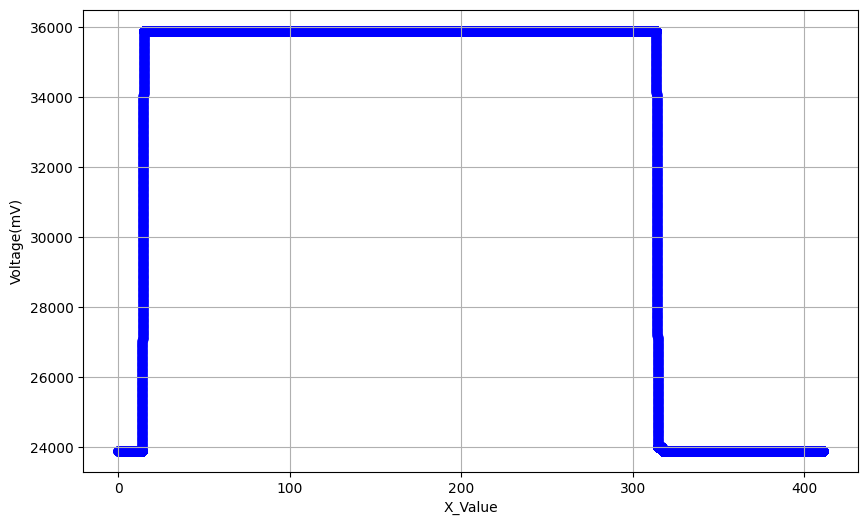

In [24]:
# data['Heat Transfer (W)'] = cp_l*rho_l*data['Flow Rate (LPM)']*(data[])

# Create scatter plot of voltage
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['X_Value'], merged_df['Voltage(mV)'], c='blue', alpha=0.5)
plt.xlabel('X_Value')
plt.ylabel('Voltage(mV)')
plt.grid(True)
plt.show()

In [25]:
time_ = merged_df['X_Value']
T_testSectionHeater_ = merged_df['Test Section Heater (degC)']
T_inlineHeater_ = merged_df['Inline Heater (degC)']
T_postPreheater_ = merged_df.get('Post Preheater Temperature (degC)')
dP_ = merged_df['Pressure Drop (kPa)']
T_i_ = merged_df['Inlet Temperature (degC)']
T_o_ = merged_df['Outlet Temperature (degC)']
V_ = merged_df['Flow Rate (LPM)']
Q_load = merged_df.get('Power(W)', default=pd.Series(np.zeros(len(merged_df))))
Q_loss = pd.Series(np.zeros(len(merged_df)))  # TODO: Calibrate for losses with Q_loss = a*(T_base-b) linear regression
Q_loss = a*(T_testSectionHeater_-b)
Q_hf = Q_load - Q_loss
q_base = Q_hf / A_base
Q_sensible = cp_l*rho_l*V_*(T_o_ - T_i_)/60  # Heat transfer raising the thermal energy of the coolant
Q_boil = Q_hf - Q_sensible
R_th = (T_testSectionHeater_-T_i_)/Q_hf
R_eff = (T_testSectionHeater_-T_i_)/q_base
x_out = Q_boil/(rho_l*V_/60*h_fg)

## Perform Linear Regression to Determine Values at an Assumed Steady State

In [26]:
# Get the lines approximating the sensor values at steady-state via linear regression
interval = time_.iloc[-1]

p = np.polyfit(time_, dP_, 1)
px = np.linspace(0, interval, 100)
py = np.polyval(p, px)

v = np.polyfit(time_, V_, 1)
vx = np.linspace(0, interval, 100)
vy = np.polyval(v, vx)

t_i = np.polyfit(time_, T_i_, 1)
t_ix = np.linspace(0, interval, 100)
t_iy = np.polyval(t_i, t_ix)

t_o = np.polyfit(time_, T_o_, 1)
t_ox = np.linspace(0, interval, 100)
t_oy = np.polyval(t_o, t_ox)

t_bp = np.polyfit(time_, T_testSectionHeater_, 1)
t_bpx = np.linspace(0, interval, 100)
t_bpy = np.polyval(t_bp, t_bpx)

regression_start_time = time_.iloc[0]
regression_end_time = time_.iloc[-1]

avg_dP = (p[0] * regression_end_time - p[0] * regression_start_time) / 2 + p[1]
avg_v = (v[0] * regression_end_time - v[0] * regression_start_time) / 2 + v[1]
avg_t_i = (t_i[0] * regression_end_time - t_i[0] * regression_start_time) / 2 + t_i[1]
avg_t_o = (t_o[0] * regression_end_time - t_o[0] * regression_start_time) / 2 + t_o[1]
avg_t_bp = (t_bp[0] * regression_end_time - t_bp[0] * regression_start_time) / 2 + t_bp[1]

print(f"Steady-State Pressure Drop: {avg_dP} kPa")
print(f"Steady-State Flow Rate: {avg_v} LPM")
print(f"Steady-State Inlet Temperature: {avg_t_i} degC")
print(f"Steady-State Outlet Temperature: {avg_t_o} degC")
print(f"Steady-State Baseplate Temperature: {avg_t_bp} degC")

avg_Q = cp_l * rho_l * avg_v * (avg_t_o - avg_t_i) / 60
avg_R_tot = (avg_t_bp - avg_t_i) / avg_Q

print(f"Steady-State Heat Transfer to Coolant, Q: {avg_Q} W")
print(f"Steady-State 1-Phase Thermal Resistance, R_tot: {avg_R_tot} K/W")

Steady-State Pressure Drop: 1.0410850945353047 kPa
Steady-State Flow Rate: 0.40000511147682866 LPM
Steady-State Inlet Temperature: 95.00309812992676 degC
Steady-State Outlet Temperature: 98.34227718288297 degC
Steady-State Baseplate Temperature: 120.34705562788857 degC
Steady-State Heat Transfer to Coolant, Q: 89.93895619377503 W
Steady-State 1-Phase Thermal Resistance, R_tot: 0.2817906563576057 K/W


## Create Plots

#### Flow Rate vs Time

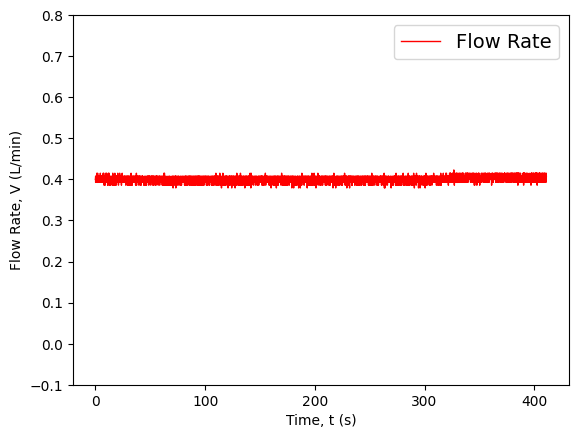

In [27]:
plt.figure()
plt.plot(time_, V_, color='red', linewidth=1)
# plt.plot(vx, vy, color='blue', linewidth=1)
plt.ylim([-0.1, 0.8])
# plt.xlim([280, 335])
plt.xlabel('Time, t (s)')
plt.ylabel('Flow Rate, V (L/min)')
plt.legend(['Flow Rate'], loc='best', fontsize=14)
plt.show()

#### Pressure Drop vs Time

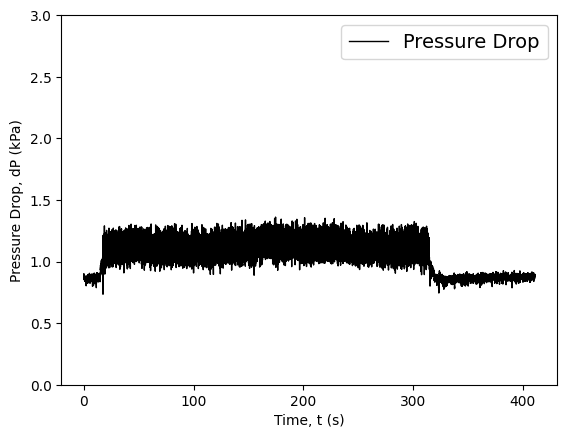

In [28]:
plt.figure()
plt.plot(time_, dP_, color='black', linewidth=1)
# plt.plot(vx, vy, color='blue', linewidth=1)
# plt.xlim([500, 525])
plt.ylim([0, 3])
plt.xlabel('Time, t (s)')
plt.ylabel('Pressure Drop, dP (kPa)')
plt.legend(['Pressure Drop'], loc='best', fontsize=14)
plt.show()

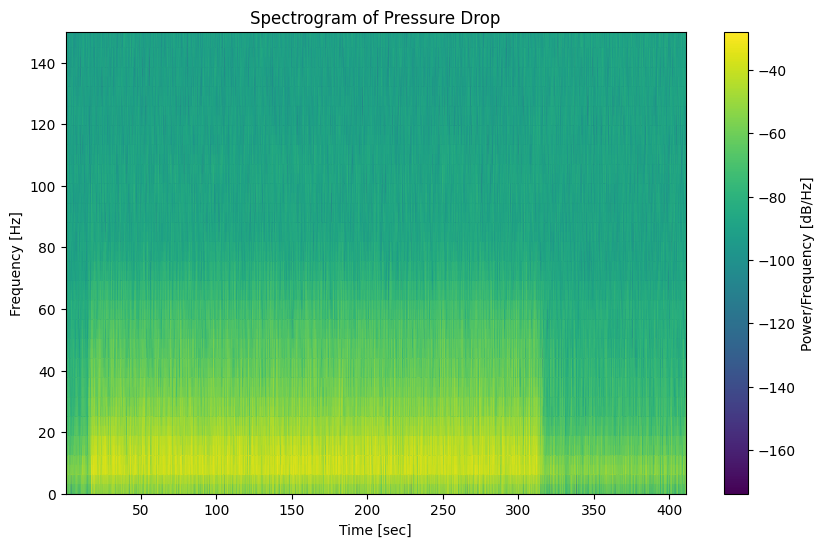

In [29]:
# Create the spectrogram
plt.figure(figsize=(10, 6))
f, t, Sxx = signal.spectrogram(dP_, fs=1/(time_[1]-time_[0]))  # fs is the sampling frequency

# Plot the spectrogram
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Pressure Drop')
plt.colorbar(label='Power/Frequency [dB/Hz]')
# plt.ylim([0, f.max()])  # Limit the y-axis to the maximum frequency
# plt.xlim([0, 85])
plt.ylim([0, 150])
plt.show()

#### Temperature vs Time

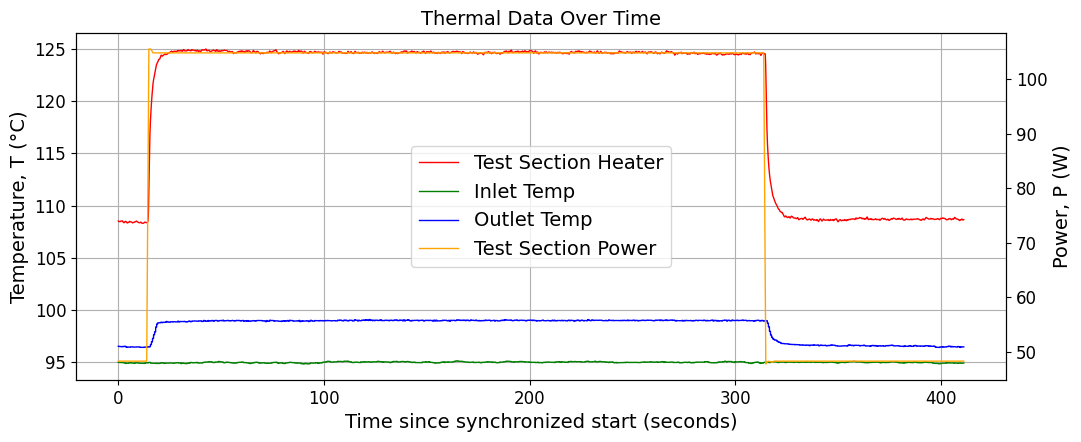

In [30]:
fig, ax1 = plt.subplots(figsize=(12,4.5))

# Plot temperature data
T_test_section_line, = ax1.plot(merged_df['Seconds since start'], merged_df['Test Section Heater (degC)'], color='red', linewidth=1, label='Test Section Heater')
T_i_line, = ax1.plot(merged_df['Seconds since start'], merged_df['Inlet Temperature (degC)'], color='green', linewidth=1, label='Inlet Temp')
T_o_line, = ax1.plot(merged_df['Seconds since start'], merged_df['Outlet Temperature (degC)'], color='blue', linewidth=1, label='Outlet Temp')
# T_inline_line, = ax1.plot(merged_df['Seconds since start'], merged_df['Inline Heater (degC)'], color='pink', linewidth=1, label='Inline Heater')

# Add horizontal black line at 95°C
# ax1.axhline(y=95, color='black', linestyle='-', linewidth=1)
# Add vertical black line
# ax1.axvline(x=55, color='black', linestyle='-', linewidth=1)

# Create a second y-axis for the power data
ax2 = ax1.twinx()
# P_test_section_line, = ax2.plot(TestSectionPSU_data['Seconds since start'], TestSectionPSU_data['Power(W)'], color='yellow', linewidth=1, label='Test Section Power')
P_test_section_line, = ax2.plot(merged_df['Seconds since start'], Q_load, color='orange', linewidth=1, label='Test Section Power')

# Set plot parameters
ax1.grid(True)
# ax1.set_ylim([94, 101])
# ax1.set_xlim([0, 1100])
ax1.set_xlabel('Time since synchronized start (seconds)', fontsize=14)
ax1.set_ylabel('Temperature, T (°C)', fontsize=14)
ax2.set_ylabel('Power, P (W)', fontsize=14)

# Increase tick label font size
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Legend and layout adjustments
lines = [T_test_section_line, T_i_line, T_o_line, P_test_section_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best', fontsize=14)
ax1.set_title('Thermal Data Over Time', fontsize=14)

plt.show()

#### Heat Transfer Rates vs Time

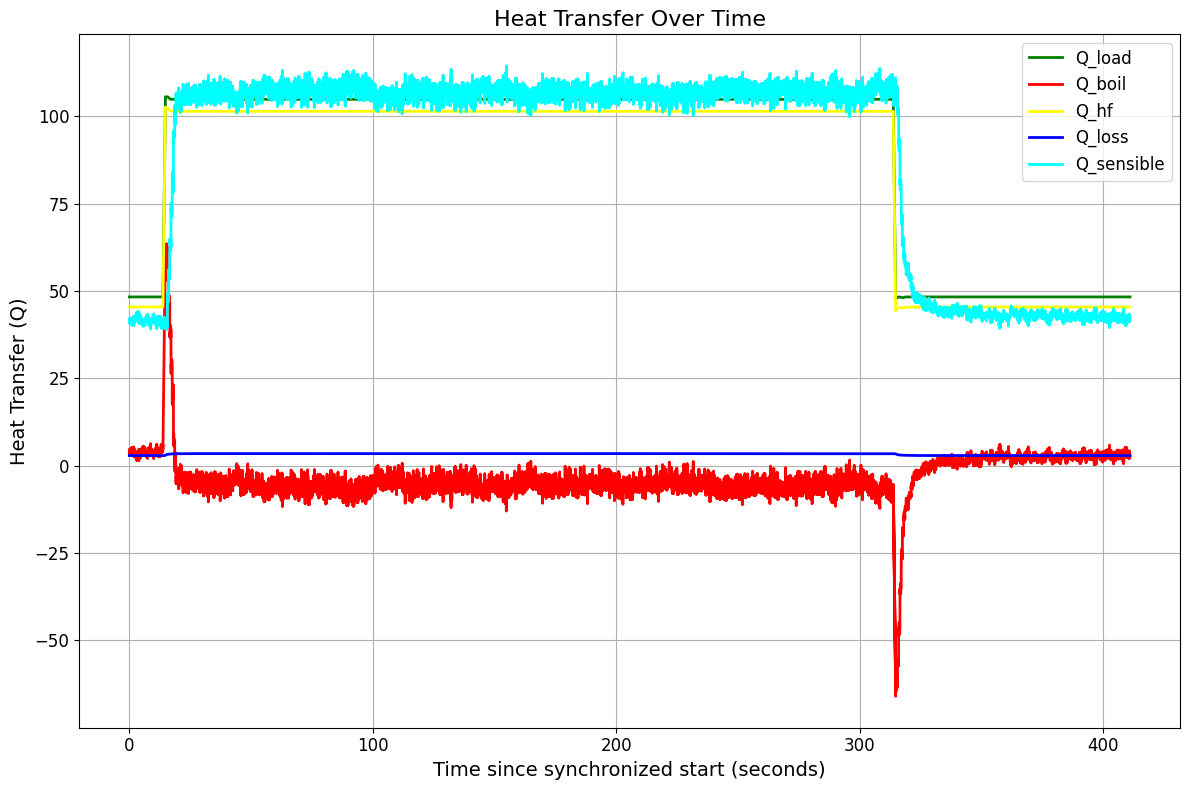

In [31]:
fig, ax1 = plt.subplots(figsize=(12, 8))  # Increased figure size for better visibility

Q_load_curve, = ax1.plot(merged_df['Seconds since start'], Q_load, color='green', linewidth=2, label='Q_load')
Q_boil_curve, = ax1.plot(merged_df['Seconds since start'], Q_boil, color='red', linewidth=2, label='Q_boil')
Q_hf_curve, = ax1.plot(merged_df['Seconds since start'], Q_hf, color='yellow', linewidth=2, label='Q_hf')
Q_loss_curve, = ax1.plot(merged_df['Seconds since start'], Q_loss, color='blue', linewidth=2, label='Q_loss')
Q_sensible_curve, = ax1.plot(merged_df['Seconds since start'], Q_sensible, color='cyan', linewidth=2, label='Q_sensible')

# Set plot parameters
ax1.grid(True)
ax1.set_xlabel('Time since synchronized start (seconds)', fontsize=14)
ax1.set_ylabel('Heat Transfer (Q)', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)  # Increase tick label size

# Legend and layout adjustments
lines = [Q_load_curve, Q_boil_curve, Q_hf_curve, Q_loss_curve, Q_sensible_curve]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best', fontsize=12)

plt.title('Heat Transfer Over Time', fontsize=16)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

#### Quality vs Time

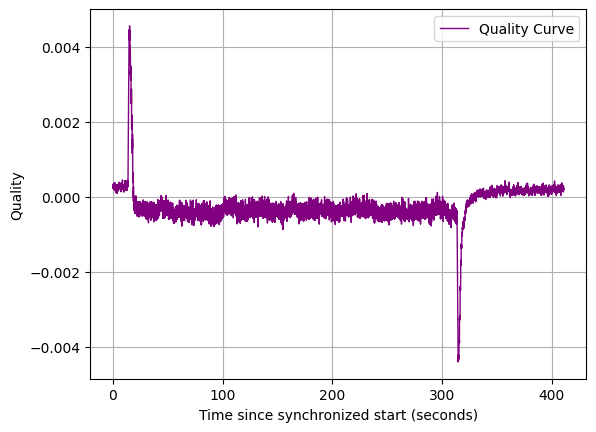

In [32]:
fig, ax1 = plt.subplots()
Quality_curve, = ax1.plot(merged_df['Seconds since start'], x_out, color='purple', linewidth=1, label='Quality Curve')
# Set plot parameters
ax1.grid(True)
# ax1.set_xlim([90, 220])
ax1.set_xlabel('Time since synchronized start (seconds)')
ax1.set_ylabel('Quality')

# Legend and layout adjustments
lines = [Quality_curve]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')

plt.show()

#### Boiling Curve

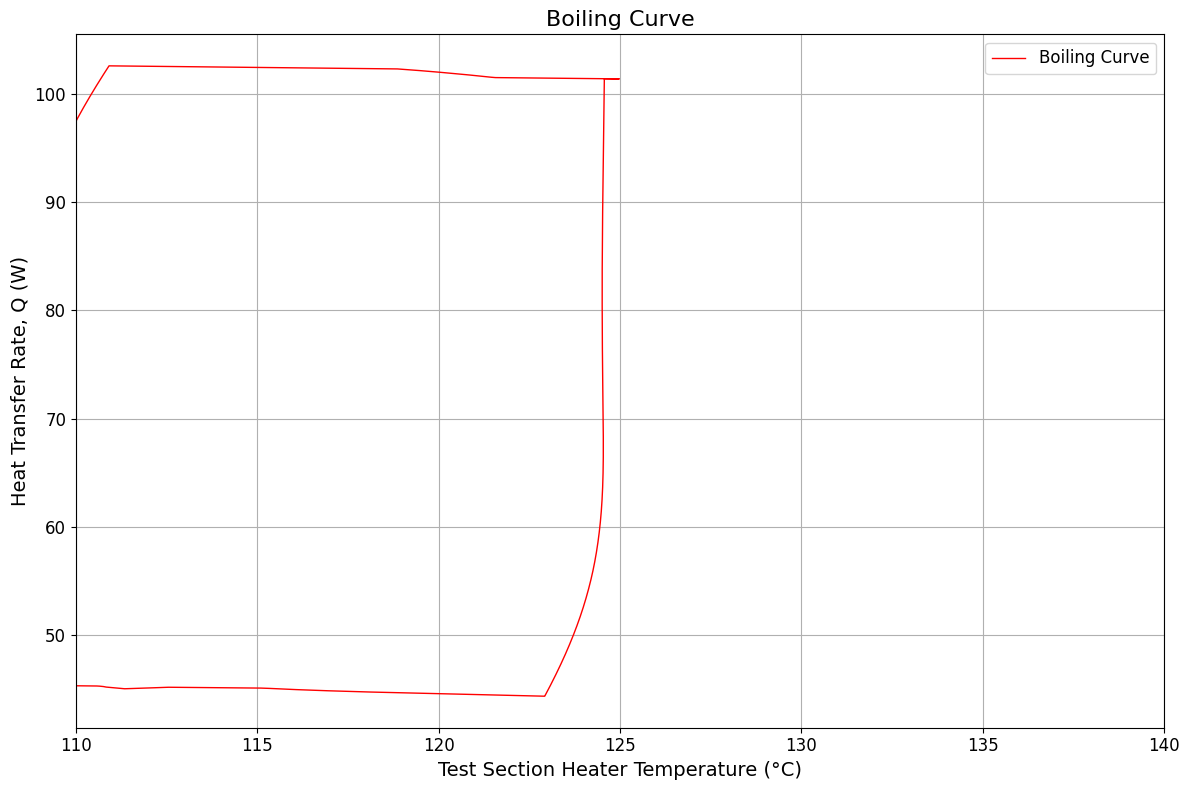

In [33]:
fig, ax1 = plt.subplots(figsize=(12,8))
Boiling_curve, = ax1.plot(merged_df['Test Section Heater (degC)'], Q_hf, color='red', linewidth=1, label='Boiling Curve')

# Set plot parameters
ax1.grid(True)
ax1.set_xlim([110, 140])
ax1.set_xlabel('Test Section Heater Temperature (°C)', fontsize=14)
ax1.set_ylabel('Heat Transfer Rate, Q (W)', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)  # Increase tick label size

# Legend and layout adjustments
ax1.legend(fontsize=12, loc='best')

plt.title('Boiling Curve', fontsize=16)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

#### Heat Transfer & Thermal Resistance vs Time

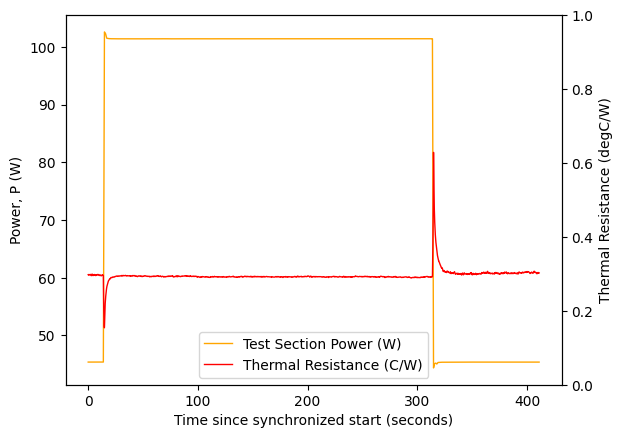

In [34]:

fig, ax1 = plt.subplots()
Q_line, = ax1.plot(merged_df['Seconds since start'], Q_hf, color='orange', linewidth=1, label='Test Section Power (W)')
ax2 = ax1.twinx()
R_th_line, = ax2.plot(merged_df['Seconds since start'], R_th, color='red', linewidth=1, label='Thermal Resistance (C/W)')
ax2.set_ylim([0, 1])
# ax2.set_xlim([0, 790])
# Legend and layout adjustments
ax1.set_xlabel('Time since synchronized start (seconds)')
ax1.set_ylabel('Power, P (W)')
ax2.set_ylabel('Thermal Resistance (degC/W)')
lines = [Q_line, R_th_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')
plt.show()

#### AE parameters vs Heat Transfer Rate

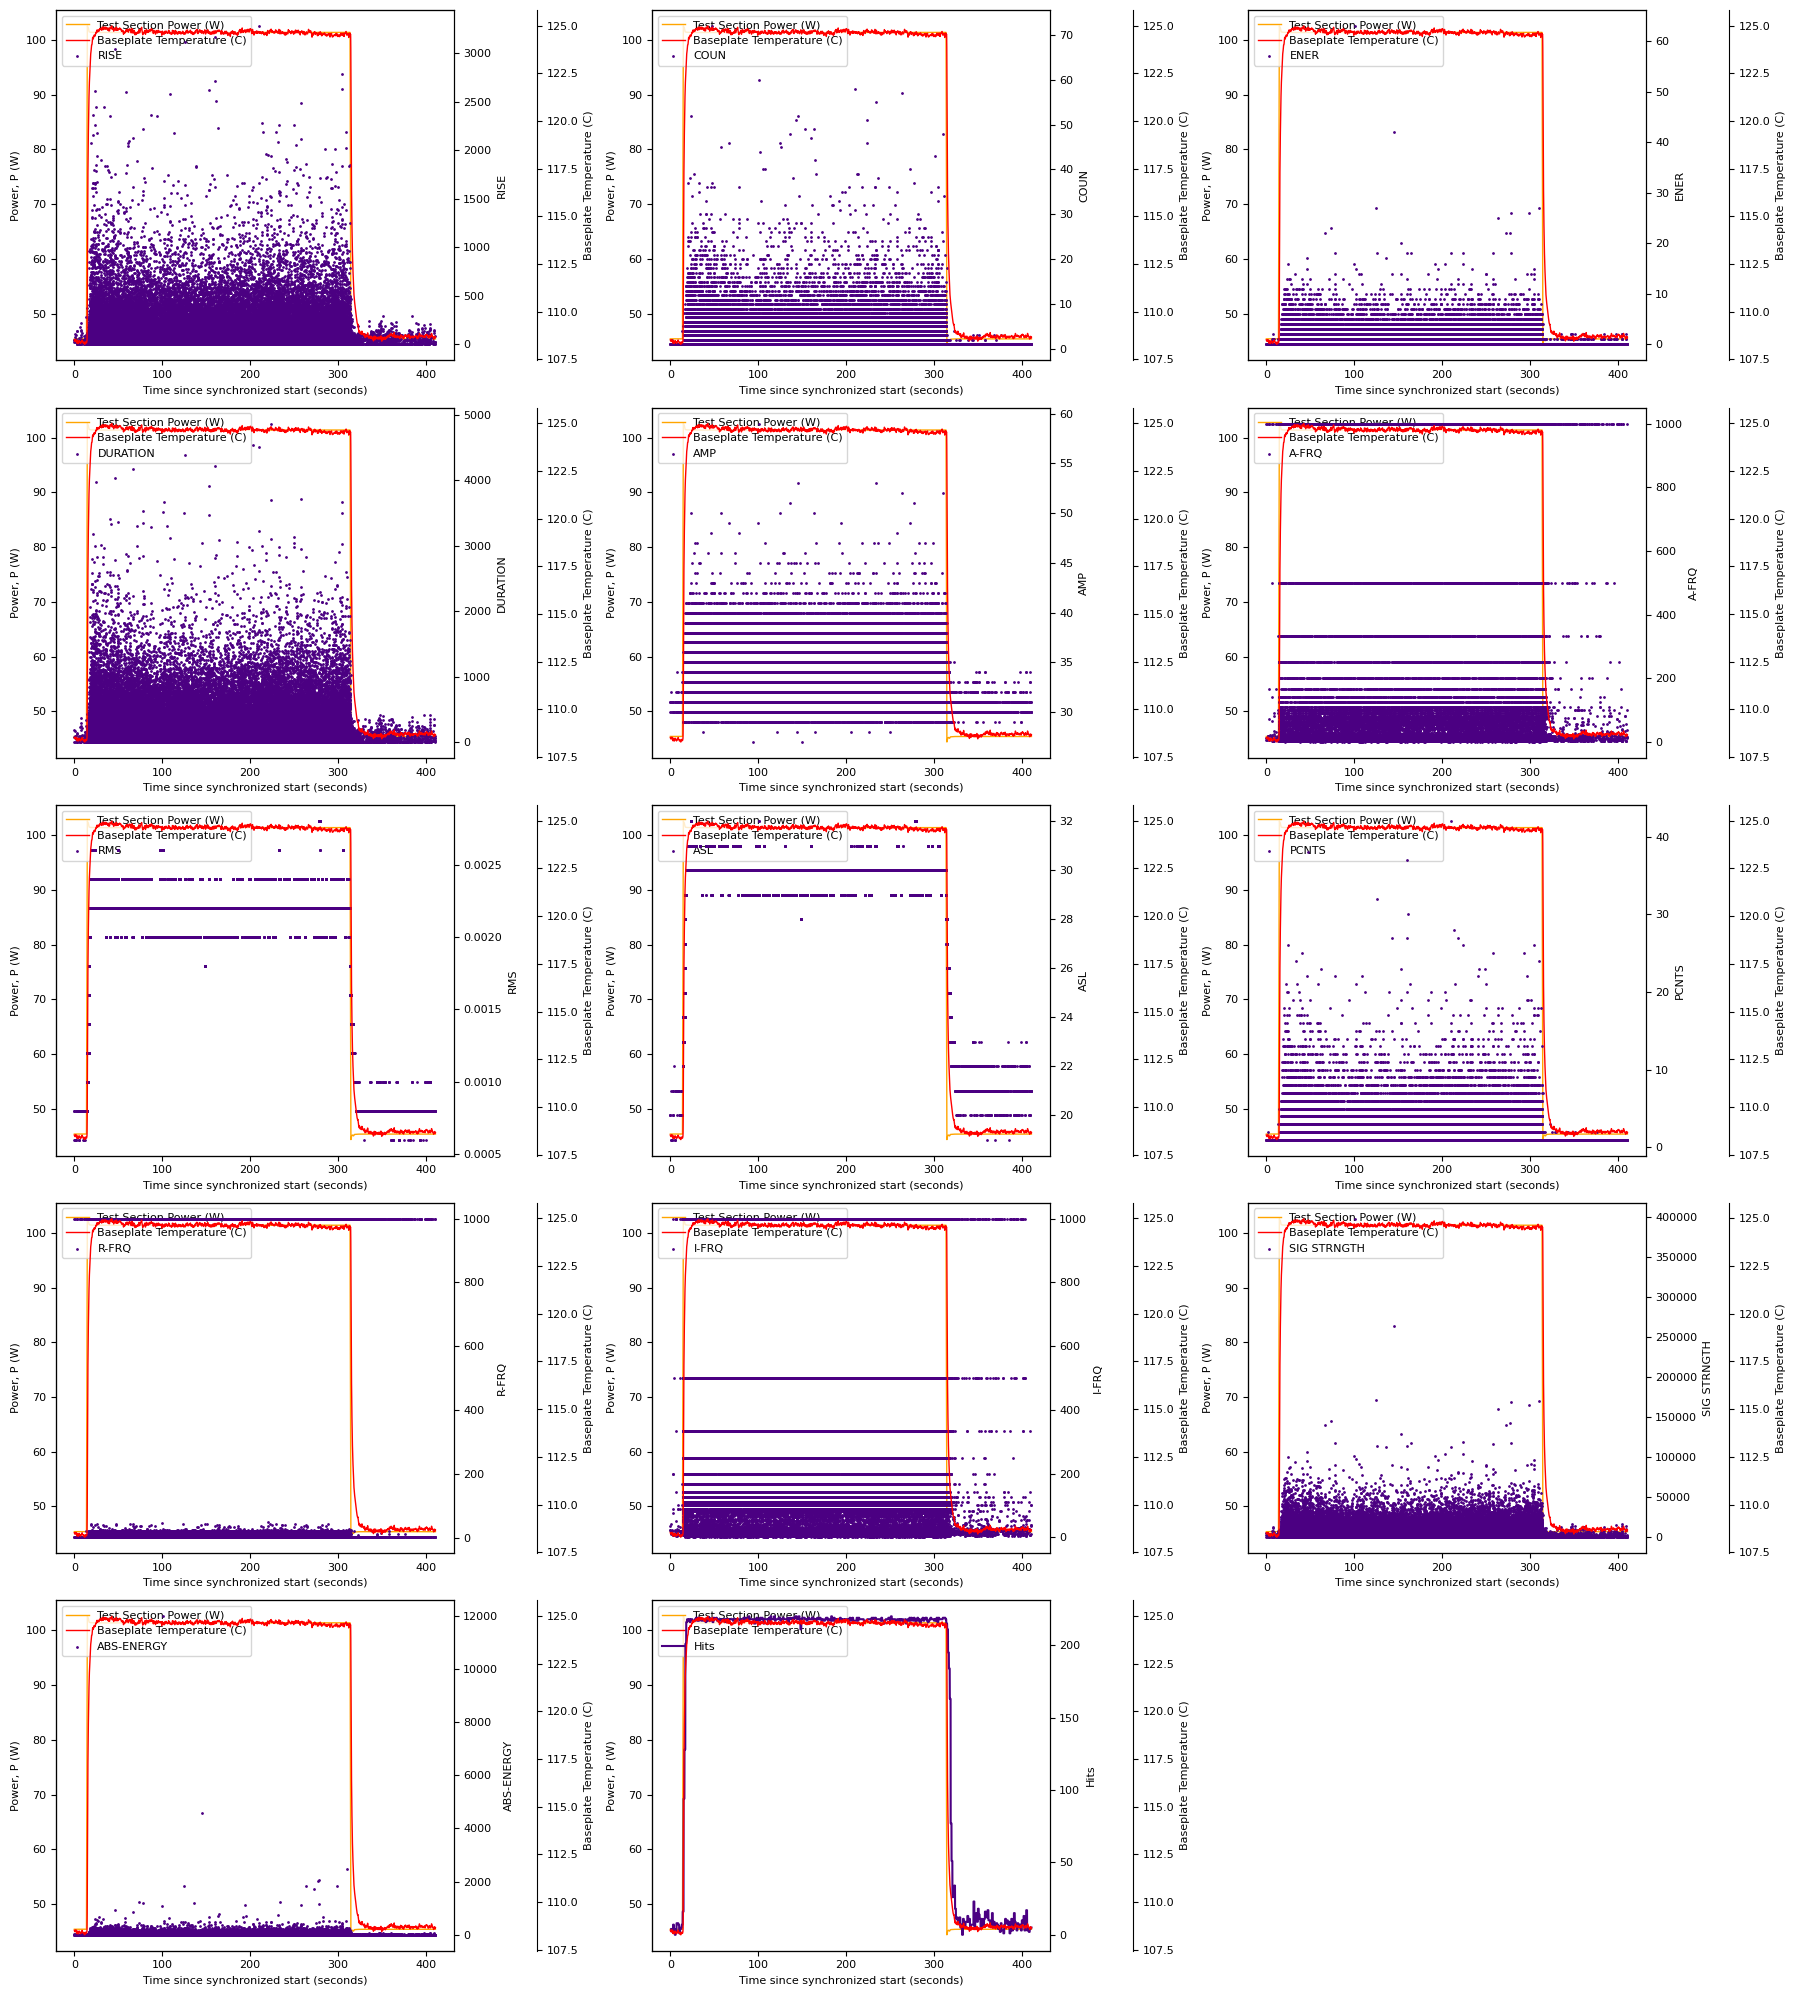

In [35]:
AE_features_to_plot = [
    {'name': 'RISE', 'plot_type': 'scatter'}, 
    {'name': 'COUN', 'plot_type': 'scatter'}, 
    {'name': 'ENER', 'plot_type': 'scatter'}, 
    {'name': 'DURATION', 'plot_type': 'scatter'}, 
    {'name': 'AMP', 'plot_type': 'scatter'}, 
    {'name': 'A-FRQ', 'plot_type': 'scatter'}, 
    {'name': 'RMS', 'plot_type': 'scatter'}, 
    {'name': 'ASL', 'plot_type': 'scatter'}, 
    {'name': 'PCNTS', 'plot_type': 'scatter'}, 
    {'name': 'R-FRQ', 'plot_type': 'scatter'}, 
    {'name': 'I-FRQ', 'plot_type': 'scatter'}, 
    {'name': 'SIG STRNGTH', 'plot_type': 'scatter'}, 
    {'name': 'ABS-ENERGY', 'plot_type': 'scatter'},
    {'name': 'Hits', 'plot_type': 'line'},
]

trigger_delay = 1.0

num_subplots = len(AE_features_to_plot)
columns = 3
rows = math.ceil(num_subplots / columns)  # Calculate the number of rows needed
mpl.rcParams['font.size'] = 8

# Create a figure with a specified size
fig = plt.figure(figsize=(18, rows * 4))

# Create a GridSpec with specified height and width ratios
gs = gridspec.GridSpec(rows, columns, height_ratios=[1]*rows, width_ratios=[1]*columns)

# Create subplots using the GridSpec
axs = []
for r in range(rows):
    for c in range(columns):
        if len(axs) < num_subplots:
            axs.append(fig.add_subplot(gs[r, c]))

for i, ax in enumerate(axs):
    if i < num_subplots:
        # Plot heat transfer line
        Q_line, = ax.plot(merged_df['Seconds since start'], Q_hf, color='orange', linewidth=1, label='Test Section Power (W)')
        
        ax2 = ax.twinx()
        ax3 = ax.twinx()

        # Offset the third axis by 60 pixels to the right
        ax3.spines['right'].set_position(('outward', 60))

        # Plot the AE feature
        feature_to_plot = AE_features_to_plot[i]['name']
        plot_type = AE_features_to_plot[i]['plot_type']
        if plot_type == 'scatter':
            AE_plot = ax2.scatter(merged_df['Seconds since start'], merged_df[feature_to_plot], color='indigo', label=feature_to_plot, s=1)
        elif plot_type == 'line':
            AE_plot, = ax2.plot(merged_df['Seconds since start'], merged_df[feature_to_plot], color='indigo', label=feature_to_plot)
        
        # Plot the baseplate temperature
        T_bp_line, = ax3.plot(merged_df['Seconds since start'], T_testSectionHeater_, color='red', linewidth=1, label='Baseplate Temperature (C)')

        ax.set_xlabel('Time since synchronized start (seconds)')
        ax.set_ylabel('Power, P (W)')
        ax2.set_ylabel(feature_to_plot)
        ax3.set_ylabel('Baseplate Temperature (C)')
        lines = [Q_line, T_bp_line, AE_plot]
        labels = [line.get_label() for line in lines]
        ax.legend(lines, labels, loc='upper left')
        # ax.set_xlim([210, 230])
        if two_phase_spans:
            for two_phase_span in two_phase_spans:
                ax.axvspan(two_phase_span[0]-trigger_delay, two_phase_span[1]-trigger_delay, color='red', alpha=0.2)
    else:
        # Hide unused subplots
        ax.set_visible(False)

plt.tight_layout()
plt.show()

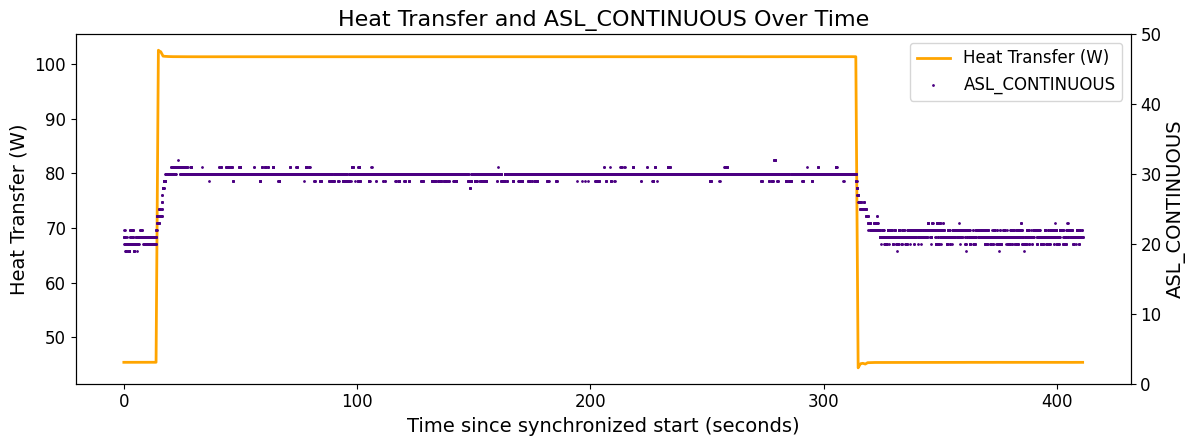

In [36]:
fig, ax1 = plt.subplots(figsize=(12,4.5))  # Increased figure size for better visibility

feature_name = 'ASL_CONTINUOUS'
# feature_name = 'ASL'

Q_line, = ax1.plot(merged_df['Seconds since start'], Q_hf, color='orange', linewidth=2, label='Heat Transfer (W)')
ax2 = ax1.twinx()
feature = ax2.scatter(merged_df['Seconds since start'], merged_df[feature_name], color='indigo', label=feature_name, s=1)

# ax1.set_xlim((0,1100))
ax2.set_ylim((0, 50))

# Increase font sizes
ax1.set_xlabel('Time since synchronized start (seconds)', fontsize=14)
ax1.set_ylabel('Heat Transfer (W)', fontsize=14)
ax2.set_ylabel(feature_name, fontsize=14)

# Increase tick label font size
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Legend and layout adjustments
lines = [Q_line, feature]
labels = ['Heat Transfer (W)', feature_name]
ax1.legend(lines, labels, loc='best', fontsize=12)

plt.title(f'Heat Transfer and {feature_name} Over Time', fontsize=16)
plt.tight_layout()
plt.show()

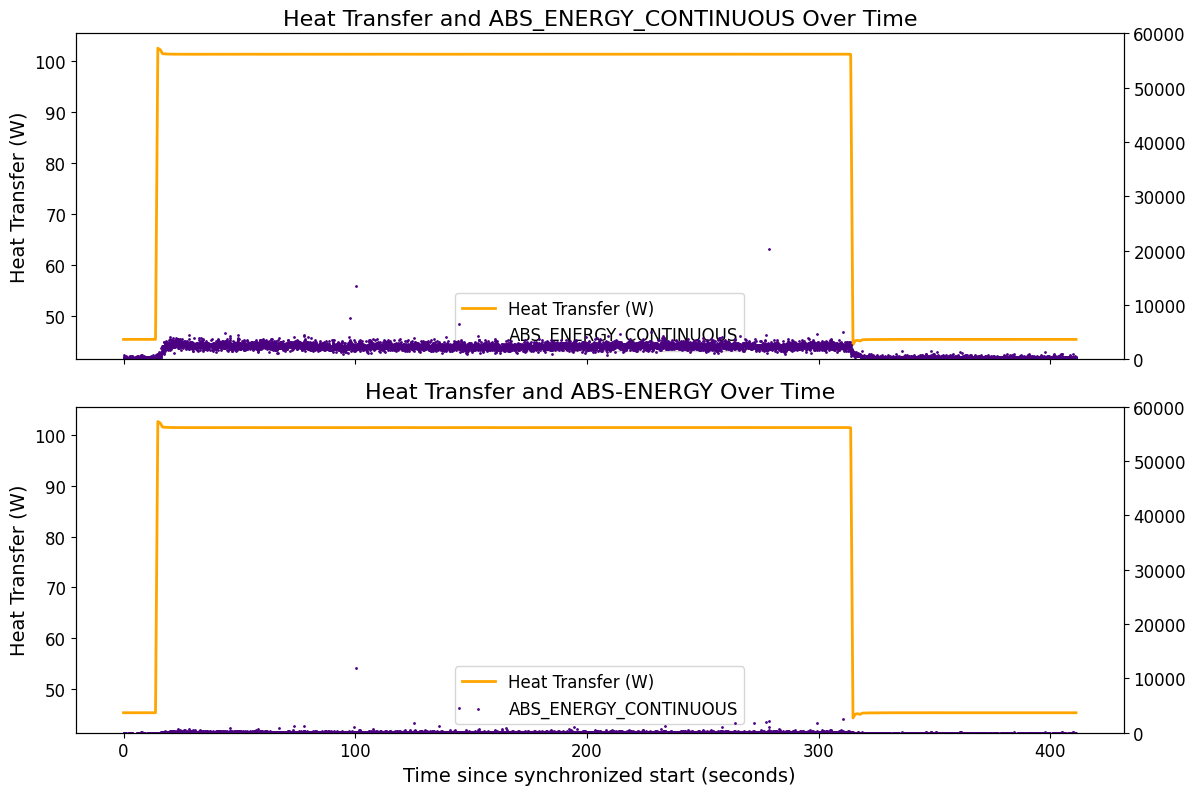

In [37]:
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)  # 2 rows, 1 column

# for ax, feature_name in zip([ax_top, ax_bottom], feature_names):
#     Q_line, = ax.plot(merged_df['Seconds since start'], Q_hf, color='orange', linewidth=2, label='Heat Transfer (W)')
#     ax_twin = ax.twinx()
#     feature = ax_twin.scatter(merged_df['Seconds since start'], merged_df[feature_name], color='indigo', label=feature_name, s=1)

#     ax.set_xlim((0, 1100))
#     if feature_name == 'RMS':
#         ax_twin.set_ylim((0, 0.012))
#     # ax_twin.set_ylim((0, 25))  # Uncomment and adjust if needed

#     # Increase font sizes
#     ax.set_xlabel('Time since synchronized start (seconds)', fontsize=14)
#     ax.set_ylabel('Heat Transfer (W)', fontsize=14)
#     ax_twin.set_ylabel(feature_name, fontsize=14)

#     # Increase tick label font size
#     ax.tick_params(axis='both', which='major', labelsize=12)
#     ax_twin.tick_params(axis='both', which='major', labelsize=12)

#     # Legend and layout adjustments
#     lines = [Q_line, feature]
#     labels = ['Heat Transfer (W)', feature_name]
#     ax.legend(lines, labels, loc='best', fontsize=12)

#     ax.set_title(f'Heat Transfer and {feature_name} Over Time', fontsize=16)

top_feature = 'ABS_ENERGY_CONTINUOUS'
bottom_feature = 'ABS-ENERGY'

top_Q_line, = ax_top.plot(merged_df['Seconds since start'], Q_hf, color='orange', linewidth=2, label='Heat Transfer (W)')
ax_top_twin = ax_top.twinx()
RMS = ax_top_twin.scatter(merged_df['Seconds since start'], merged_df[top_feature], color='indigo', label=feature_name, s=1)

# ax_top.set_xlim((0,1100))
# ax_bottom.set_xlim((0,1100))
ax_top_twin.set_ylim((0, 60000))

ax_top.set_ylabel('Heat Transfer (W)', fontsize=14)
# ax_top_twin.set_ylabel(r'V$_\mathrm{rms}$', fontsize=14)

ax_top.tick_params(axis='both', which='major', labelsize=12)
ax_top_twin.tick_params(axis='both', which='major', labelsize=12)

top_lines = [Q_line, RMS]
top_labels = ['Heat Transfer (W)', top_feature]
ax_top.legend(top_lines, top_labels, loc='best', fontsize=12)
ax_top.set_title(f'Heat Transfer and {top_feature} Over Time', fontsize=16)

bottom_Q_line, = ax_bottom.plot(merged_df['Seconds since start'], Q_hf, color='orange', linewidth=2, label='Heat Transfer (W)')
ax_bottom_twin = ax_bottom.twinx()
ASL = ax_bottom_twin.scatter(merged_df['Seconds since start'], merged_df[bottom_feature], color='indigo', label=feature_name, s=1)

ax_bottom.set_xlabel('Time since synchronized start (seconds)', fontsize=14)
ax_bottom.set_ylabel('Heat Transfer (W)', fontsize=14)
# ax_bottom_twin.set_ylabel(r'ASL (dB$_\mathrm{AE}$)', fontsize=14)
ax_bottom_twin.set_ylim((0, 60000))

ax_bottom.tick_params(axis='both', which='major', labelsize=12)
ax_bottom_twin.tick_params(axis='both', which='major', labelsize=12)

bottom_lines = [Q_line, ASL]
bottom_labels = ['Heat Transfer (W)', bottom_feature]
ax_bottom.legend(bottom_lines, top_labels, loc='best', fontsize=12)
ax_bottom.set_title(f'Heat Transfer and {bottom_feature} Over Time', fontsize=16)

# Remove xlabel from the top subplot
ax_top.set_xlabel('')

plt.tight_layout()
plt.show()

#### Flow Rate vs Time

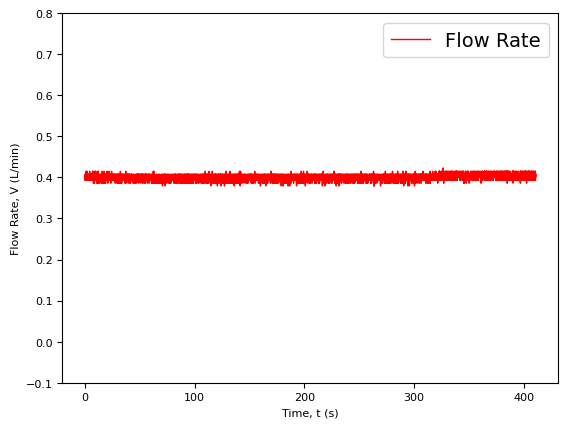

In [38]:
plt.figure()
plt.plot(time_, V_, color='red', linewidth=1)
# plt.plot(vx, vy, color='blue', linewidth=1)
plt.ylim([-0.1, 0.8])
# plt.xlim([280, 335])
plt.xlabel('Time, t (s)')
plt.ylabel('Flow Rate, V (L/min)')
plt.legend(['Flow Rate'], loc='best', fontsize=14)
plt.show()

#### Pressure Drop vs Time

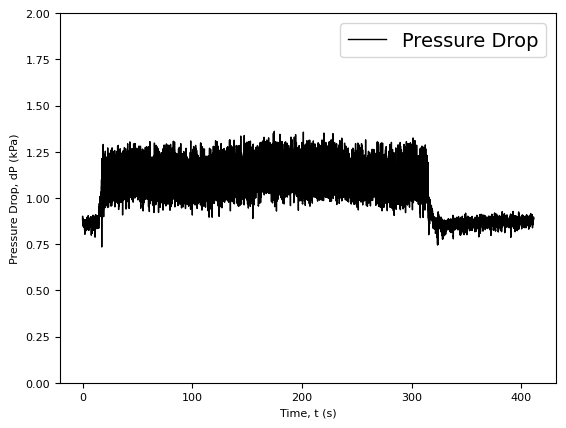

In [39]:
plt.figure()
plt.plot(time_, dP_, color='black', linewidth=1)
# plt.plot(vx, vy, color='blue', linewidth=1)
# plt.xlim([500, 525])
plt.ylim([0, 2])
plt.xlabel('Time, t (s)')
plt.ylabel('Pressure Drop, dP (kPa)')
plt.legend(['Pressure Drop'], loc='best', fontsize=14)
plt.show()

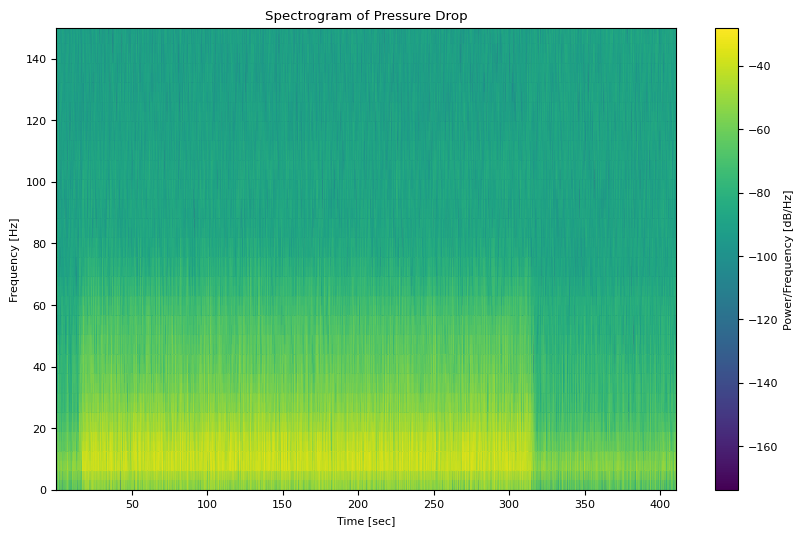

In [40]:
# Create the spectrogram
plt.figure(figsize=(10, 6))
f, t, Sxx = signal.spectrogram(dP_, fs=1/(time_[1]-time_[0]))  # fs is the sampling frequency

# Plot the spectrogram
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram of Pressure Drop')
plt.colorbar(label='Power/Frequency [dB/Hz]')
# plt.ylim([0, f.max()])  # Limit the y-axis to the maximum frequency
# plt.xlim([0, 85])
plt.ylim([0, 150])
plt.show()

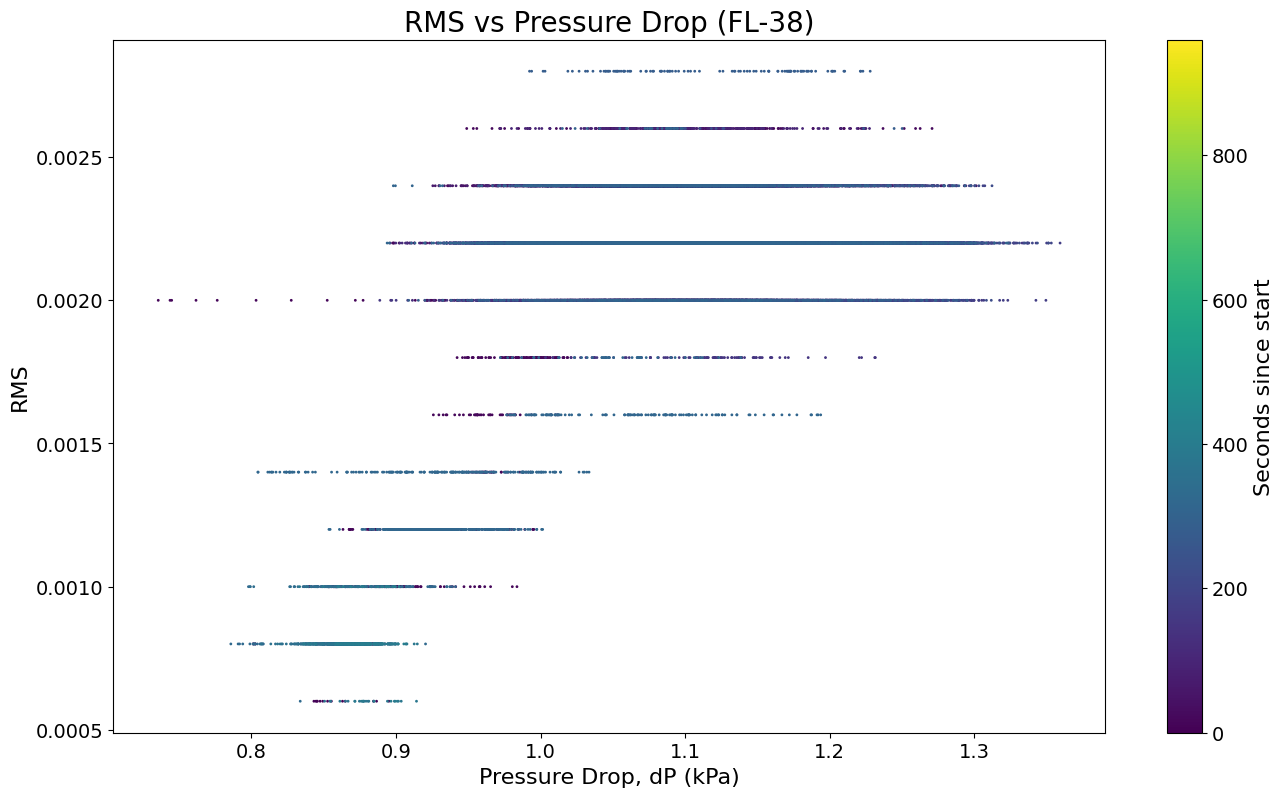

In [41]:
t_min = 0
t_max = 60*16
merged_df_2_phase = merged_df[(merged_df['Seconds since start'] >= t_min) & (merged_df['Seconds since start'] <= t_max)]

plt.figure(figsize=(16,9))

# Create a scatter plot with a colormap
scatter = plt.scatter(merged_df_2_phase['Pressure Drop (kPa)'], 
                      merged_df_2_phase['RMS'], 
                      c=merged_df_2_phase['Seconds since start'], 
                      cmap='viridis',  # You can choose different colormaps
                      norm=colors.Normalize(vmin=t_min, vmax=t_max),
                      s=1)

plt.xlabel('Pressure Drop, dP (kPa)', fontsize=16)
plt.ylabel('RMS', fontsize=16)
plt.title('RMS vs Pressure Drop (FL-38)', fontsize=20)

# Increase tick label font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Seconds since start', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

In [42]:
# plt.figure()
# plt.scatter(V_, dP_, color='black')
# plt.ylim([0, 2])
# plt.xlim([0, max_V])
# plt.xlabel('Flow Rate, V (L/min)')
# plt.ylabel('Pressure Drop, dP (kPa)')
# plt.legend(['Pressure Drop'], loc='best', fontsize=14)
# plt.show()

In [43]:
# plt.figure()
# plt.scatter(V, T_i, color='black')
# plt.ylim([0, 2])
# plt.xlim([0, max_V])
# plt.xlabel('Flow Rate, V (L/min)')
# plt.ylabel('Inlet Temperature, T_i (°C)')
# plt.legend(['Inlet Temperature'], loc='best', fontsize=14)
# plt.show()

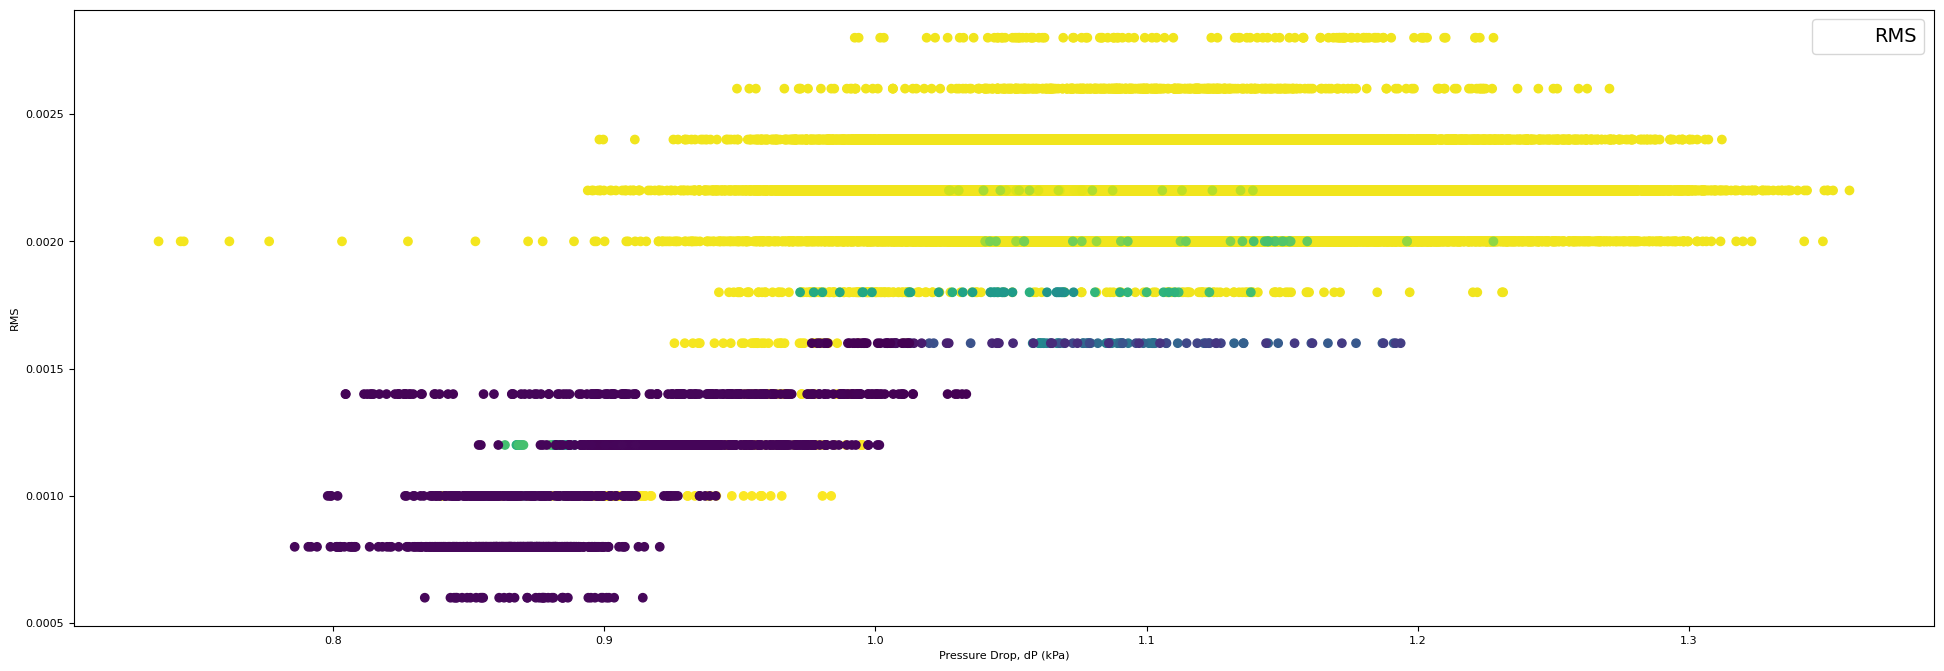

In [44]:
merged_df_2_phase = merged_df#[(merged_df['Seconds since start'] >= 100) & (merged_df['Seconds since start'] <= 900)]
plt.figure(figsize=(24,8))
# Create a scatter plot with a colormap
scatter = plt.scatter(merged_df_2_phase['Pressure Drop (kPa)'], 
                      merged_df_2_phase['RMS'], 
                    #   c=merged_df_2_phase['Seconds since start'], 
                      c=Q_hf,
                      cmap='viridis',  # You can choose different colormaps
                    #   norm=colors.Normalize(vmin=100, vmax=900)
                      )
plt.xlabel('Pressure Drop, dP (kPa)')
plt.ylabel('RMS')
plt.legend(['RMS'], loc='best', fontsize=14)
plt.show()